# ⚽ 2026 World Cup Readiness Framework - Exploratory Data Analysis

**Team:** XOH - SOOMI OH, YOO MI OH

**Date:** February 2026  

**For Executive Summary:** See `EDA_Executive.ipynb`

## Overview 
The 2026 FIFA World Cup, co-hosted across the United States, Canada, and Mexico, represents the largest edition of the tournament in history — 48 nations, three confederations of host advantage, and a genuinely open competitive landscape for the first time since the format expanded.

This report presents a data-driven framework for quantifying national team readiness ahead of that tournament. The central argument is simple: predicting World Cup performance requires more than ranking teams by FIFA rating or recent results. It requires understanding three distinct but interconnected questions simultaneously; who are the players, what kind of team do they form, and what contextual factors shape their tournament prospects.

To answer these questions, we built a three-layer analytical system grounded in StatsBomb open event data. Tournament-level team data from the 2022 World Cup and 2024 European Championship provides the tactical foundation - eight dimensions of collective behaviour that reveal how teams actually play, not how they are perceived to play. Player-level performance data spanning 2021 to 2025 across all competitions provides the individual quality layer — 10 metrics covering finishing, ball progression, attacking contribution, defensive output and pressing quality, time-decay weighted to prioritise recent form. These two independent evidence streams are synthesised into a single Readiness Score per national team, adjusted for managerial stability, club cohesion, host advantage, confederation travel factors, and tactical archetype historical success rates.

The result is not a prediction. It is a structured, auditable, football-grounded assessment of which squads are best positioned to compete — and why.

## I. Data Architecture & Sources
### 1.1 The Raw Material

We use the **StatsBomb Open Data** dataset, accessed via the official template repository scripts:

| Dataset | Format | Description |
|---|---|---|
| Matches | Parquet/CSV | Match metadata: competition, season, teams, score, date |
| Events | Parquet/CSV | 12.2M event-level rows: passes, shots, pressures, carries, etc. |
| Lineups | Parquet/CSV | Player-match lineups with positions |
| 360° Frames | Parquet/CSV | Freeze-frame tracking (for select matches only) |

Data is downloaded by running `download_data.py` per the root `README.md`, then read locally from `data/Statsbomb/`.

In [22]:
# Import eda template functions
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

import sys
import importlib
sys.path.append(str(Path('..').resolve()))

from templates.eda_starter_template import (
    header, sub, dist, desc, top, safe_run,
    analyze_sb_matches,
    analyze_sb_events,
    analyze_sb_lineups,
    analyze_sb_360,
    analyze_sb_reference,
    analyze_sb_lineups_adv,
    analyze_sb_reference_adv
)

# Import custom functions
from analysis.eda_functions import (
    overall_summary_table,
    plot_event_type_distribution,
    plot_360_coverage_analysis,
    plot_matches_market_overview,
    plot_tactical_evolution_basics,
    plot_360_player_heatmap,
    plot_player_versatility_gradient
    
)

from analysis.data_loader import load_tournament_data_8d, load_player_data_for_scoring

from analysis.team_metrics_eda import (
    plot_metric_distributions,
    plot_correlation_matrix,
    plot_tactical_scatter,
    plot_outcome_by_quadrant,
    plot_competition_radar,
    plot_tactical_consistency_scatter,
    
)

from analysis.player_metrics_eda import (
    load_all_players,
    plot_row_counts,
    plot_coverage_heatmap,
    plot_metric_distributions_pl,
    plot_minutes_distribution,
    plot_player_archetype_scatter,
    plot_quality_minutes_scatter,
    plot_player_trajectory,
    plot_player_consistency
)
STATSBOMB_DIR = Path("..") / "data" / "Statsbomb"
overall_summary_table(STATSBOMB_DIR);

                          DATASET SUMMARY: STATSBOMB CORE ENGINE                          
Dataset         Records         Coverage                  Details                  
------------------------------------------------------------------------------------------
Matches         3,464           21 competitions           ~3,518 events/match      
Events          12,188,949      35 types                  99.2% w/ loc             
Lineups         165,820         10,803 players            26 positions             
360 Tracking    15,584,040      323 matches               9.3% coverage            


### 1.2 Match Data: Competition Coverage & Temporal Scope

#### Dataset at a Glance
- **3,464 matches** across 21 competitions
- **Temporal:** 54% concentrated in 2015-2016 (1,860 matches). Pre-2015: 425 scattered matches. Post-2016: 1,179 matches over 8 years.
- **Competitions:** La Liga 25%, Ligue 1 13%, Premier League 12%, Serie A 11%, Bundesliga 10%. Women's football 9.4%.
- **Outcomes:** 45.2% home wins, 23.0% draws, 31.8% away wins. 2.85 goals/match average.
- **Quality:** No duplicate IDs. Missing data limited to non-essential fields.

Saved: figures/matches_overview.png


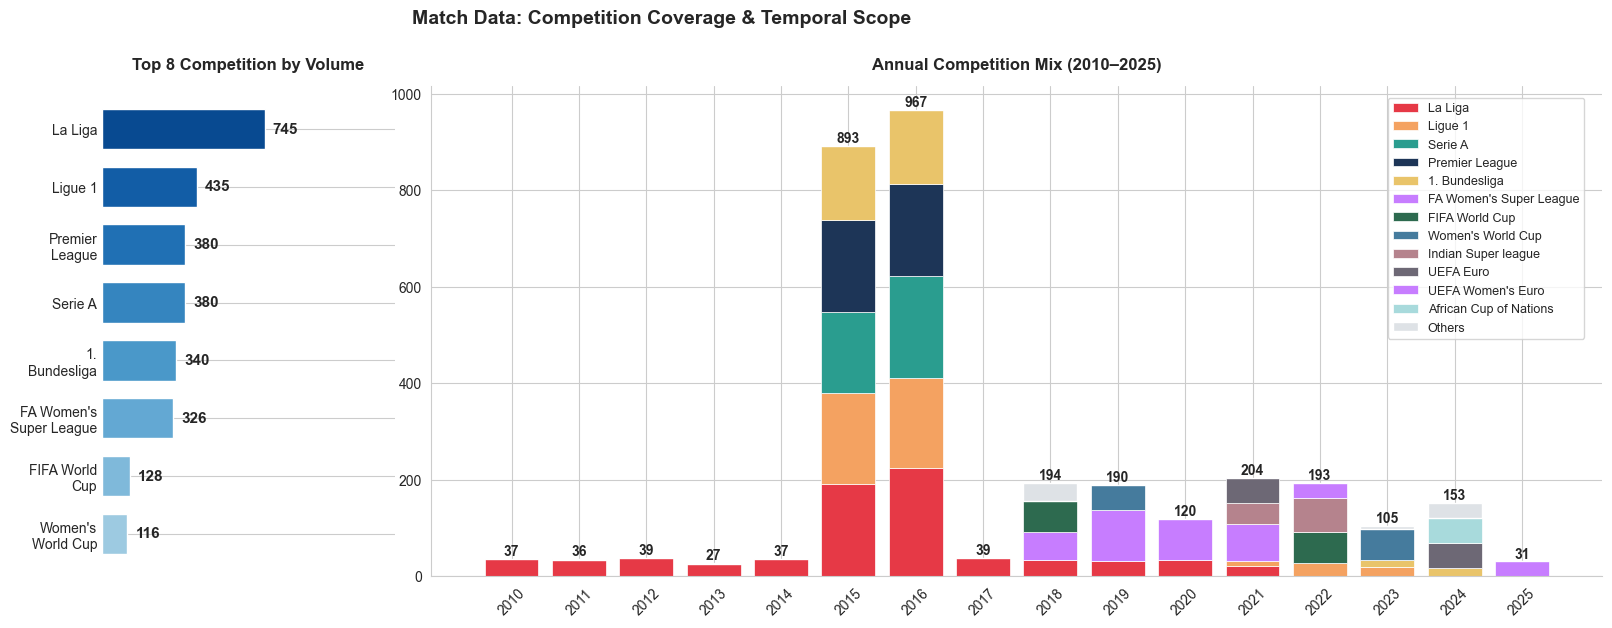

In [2]:
plot_matches_market_overview(STATSBOMB_DIR)

#### Temporal Distribution & The Case for Recency

The dataset spans decades, but the distribution is heavily skewed; 2015/16 alone accounts for over half of all club match records, driven by StatsBomb’s early data releases. As the match volume charts illustrate, this Legacy Spike from 2015 to 2016 (peaking at 967 matches in 2016) is a statistical artifact of concentrated collection rather than a global tactical inflection point. Including this era, which is dominated by a historical La Liga "monoculture" of 748 total matches, would tether the model to a bygone style of play that is too dated to inform a 2026 prediction reliably.

We use 2021 onwards across both data streams, but with different scopes to ensure a Modern Tactical Sample. For player quality, five seasons of data (2021–2025) across top club and international competitions, including the "Big Five" European leagues, provides enough volume to separate genuine quality from single-season noise while staying within the modern era. For team archetypes, we focus specifically on the 2022 World Cup, 2024 Euro, and Copa America tournament data to capture the most current competitive trends.

The tradeoff is deliberate; recency and relevance over raw volume. This strategy is further validated by the diversity and emerging trends visible in the broader dataset:

- **Diversification of the Global Game:** While La Liga represents the largest historical volume, the modern window shows a more balanced distribution across the Premier League, Bundesliga, and Serie A, providing a more rounded "Global Meta."

- **Emergence of New Markets:** The dataset highlights the professionalization of new regions, such as the Indian Super League, which makes a notable appearance specifically in the 2021 and 2022 samples.

- **Expansion of Professional Coverage:** Interestingly, the broader metadata shows a significant surge in the women's professional game, with the FA Women’s Super League (316 matches) and Women's World Cup (116 matches) representing a major portion of StatsBomb's recent efforts. While our model focuses on the men’s 2026 World Cup, this observation underscores that the post-2021 era is the most comprehensive and professionally recorded period in the history of the data.

By centering our analysis on this 2021–2025 cluster, we move away from a legacy-heavy dataset toward a balanced, modern sample that reflects the current competitive landscape.

### 1.3 Event Data: The Pulse of the Game

#### Dataset at a Glance
- **12,188,949 events** across 3,464 matches
- **Distribution:** Pass 27.8%, Ball Receipt 26.0%, Carry 21.6%, Pressure 9.1%, Shot 0.7%
- **Barcelona bias:** 10.2% of all events. Top 10 players all Barcelona 2010s (Messi, Busquets, Xavi, Iniesta).
- **Shot quality:** 9,383 total xG across 88,023 shots (0.107 avg). Only 8.1% qualify as big chances (xG > 0.3). Median 0.055 suggests many speculative efforts.
- **Passes:** 77.7% completion rate
- **Temporal:** 50.4% first half, 49.2% second half
- **Quality:** No duplicate IDs. 99.25% have location data. 20.9% under pressure.

Saved: figures/event_type_dis.png


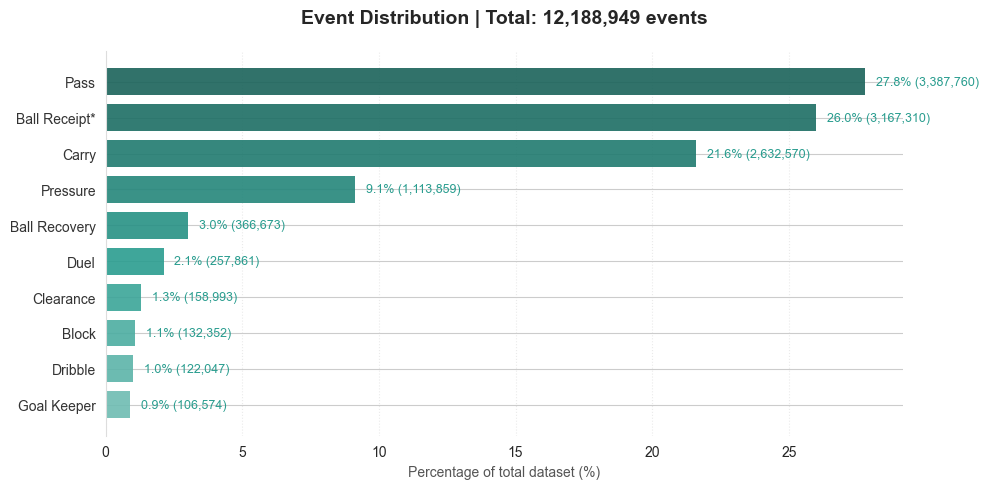

In [3]:
import analysis.eda_functions
importlib.reload(analysis.eda_functions)
from analysis.eda_functions  import * 
plot_event_type_distribution(STATSBOMB_DIR)

The event dataset represents a highly granular tactical landscape, encompassing **12.2M events across 3,464 matches (~3,519 events per match)** with a clear concentration on high-value actions. Unlike raw GPS tracking, which is limited to physical positioning, this event-based architecture captures the intentionality and decision-making of players, with 67% of all data consisting of active tactical events such as Passes (27.8%), Carries (21.6%), and Pressures (9.1%). This density provides "Excellent" coverage for profiling possession and progression (49.4%) and "Good" defensive benchmarking (12%), ensuring the dataset is action-rich rather than just tracking-rich. By focusing on these 35 unique event types, we shift the analytical focus from where a player is to how a team functions, enabling a level of tactical profiling, capturing the "DNA" of modern high-pressing and verticality, that is impossible with location-only data.

Saved: figures/tactical_evolution.png


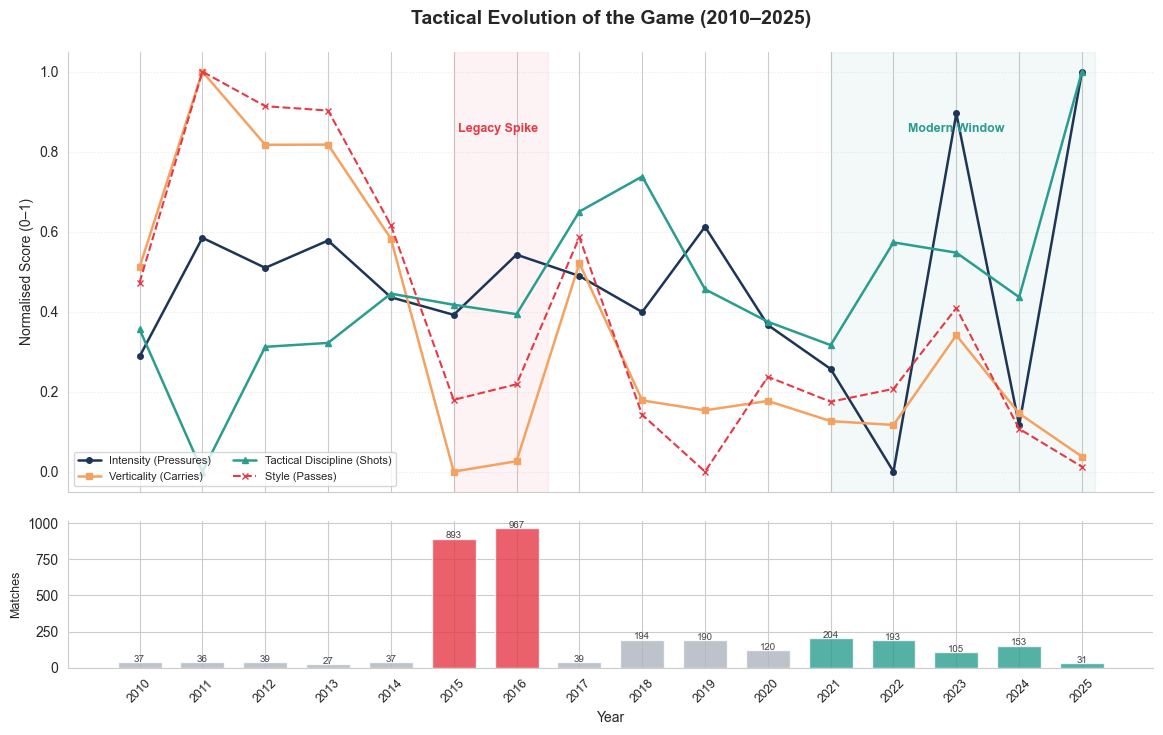

In [4]:
plot_tactical_evolution_basics(STATSBOMB_DIR)

#### Temporal Segmentation

The longitudinal analysis spanning 2010 to 2025 serves as more than just a timeline; it provides the visual mandate for our data windowing strategy. While the **Legacy Spike of 2015–2016** presents an alluring volume of approximately 1,800 matches, a deeper look reveals it to be a statistical artifact of data collection rather than a genuine tactical inflection point. Including this "Messi-era" concentration would tether our model to a bygone style of play, effectively "polluting" the predictive engine with outdated patterns.

By contrast, the **Modern Meta (2021–2025)** represents a period of unprecedented convergence. It is here that we see key metrics reach their highest sustained levels, with the synchronization of Intensity (Pressures) and Style (Passes) marking this as the most tactically evolved segment of the dataset. Shifting our focus to this 2021–2025 cluster allows us to train the model on a "Tactical Equilibrium." In this state, playstyles have become more specialized and consistent, offering the clean, high-fidelity signal necessary for accurate 2026 projections.

#### The Modern Meta - Defining the 2026 Blueprint

The shift into this modern window reveals a fundamental transformation in the global game, defined by three pillars of tactical evolution. First, we have witnessed **The Systematization of Pressure.** Post-2021, defensive intensity moved from erratic, volatile spikes to a high, sustained "floor." Aggressive pressing has transitioned from a niche tactical gamble to a global baseline requirement for elite performance.

Parallel to this physical shift is a strategic **Optimization of Shot Quality.** Despite lower overall match volumes compared to the 2016 peak, the **Shots (Tactical Discipline)** metric reached new heights in the modern window. This "Moneyball" effect indicates that teams have become far more structured in their box entry patterns, ruthlessly prioritizing high-value xG opportunities over the speculative, low-percentage shooting that characterized the previous decade.

Finally, we are observing The Rise of Verticality. The simultaneous ascent of Verticality (Carries) and Intensity signals the definitive end of the "tiki-taka" era and the dawn of the "transition era." Modern tactical frameworks now emphasize bypassing midfields through explosive, direct carries. This marriage of physical power and vertical intent is not just a trend — it is the blueprint that will likely define the tactical landscape of the 2026 World Cup.

### 1.4 Lineup Data: Who Was on the Pitch
#### Dataset at a Glance
- **165,820 entries** across 3,464 matches with 10,808 unique players identified.
- **Participation:** 58.3% of the recorded lineup entries actually saw game time (96,698 players/instances).
- **Substitutions:** 5.9 avg per match. Starters averaged 84.7 min, while substitutes averaged 21.5 min of playing time.
- **Playing Time:** 55.8% played 90+ min, 18.5% played 60-90 min, 9.0% played 30-60 min, and 16.7% played under 30 min.
- **Cards:** 19,606 total cards (11.8% of records). 96.5% were Yellow Cards. Sergio Busquets leads the disciplinary table with 130 cards.
- **Quality:** 60,491 duplicate (match_id, player_id) pairs detected (36.5%), representing significant tactical flexibility and position changes during matches.

In [5]:
lineups_results = safe_run(analyze_sb_lineups_adv, "lineups")


  STATSBOMB: LINEUPS
Records: 165,820 | Matches: 3,464 | Unique Players: 10,808
Quality: 60,491 duplicate (match_id, player_id) pairs (36.5%), likely position changes.
Participation: Only 58.3% actually played (96,698).
Substitutions: 5.9 avg per match. Starters 84.7 min avg, subs 21.5 min avg.

--- Position Distribution ---
shape: (10, 2)
┌───────────────────────┬───────┐
│ position_name         ┆ count │
│ ---                   ┆ ---   │
│ str                   ┆ u32   │
╞═══════════════════════╪═══════╡
│ null                  ┆ 34179 │
│ Center Forward        ┆ 9325  │
│ Right Center Back     ┆ 9021  │
│ Left Center Back      ┆ 8888  │
│ Right Wing            ┆ 8780  │
│ Left Wing             ┆ 8653  │
│ Right Back            ┆ 8431  │
│ Left Back             ┆ 8103  │
│ Goalkeeper            ┆ 7029  │
│ Right Center Midfield ┆ 6872  │
└───────────────────────┴───────┘

--- Playing Time Distribution ---
shape: (4, 2)
┌───────────┬───────┐
│ bin       ┆ count │
│ ---       ┆ ---   

#### Super-Sub Noise & The Bench Problem
The data shows a massive gap in "mileage": Starters average 84.7 minutes, while subs average just 21.5. This creates a massive trap for "Per-90" metrics; a sub who scores in a 10-minute cameo will look like prime Pelé on paper (the "Super-Sub Bias"). To keep the 2026 predictions grounded in reality, we have to implement a minimum threshold (e.g., 270 minutes or three full matches). This filters out those who are just "bench-warmers" and ensures our Readiness Score is built on Foundation Players - the workhorses who can actually survive the physical grind of a 48-team tournament.

#### The "Position Paradox" (36.5% Data Duplication)
A quick look at the lineups shows that 36.5% of the records are "duplicates"; the same player appearing twice in one match. In data terms, that’s a headache, but in football terms, it’s **Tactical Plasticity.** It’s evidence of managers like Scaloni or Southgate moving a player from the wing to the center mid-game to chase a result. Because these players are "shape-shifters," I can't just pick a random position for them. For the 2026 Readiness Score, we should use a "Minutes-Weighted Primary Position." This ensures we classify a player by where they actually put in the work, rather than a 10-minute emergency shift as a makeshift wing-back.

Saved: figures/profile_evol_example.png


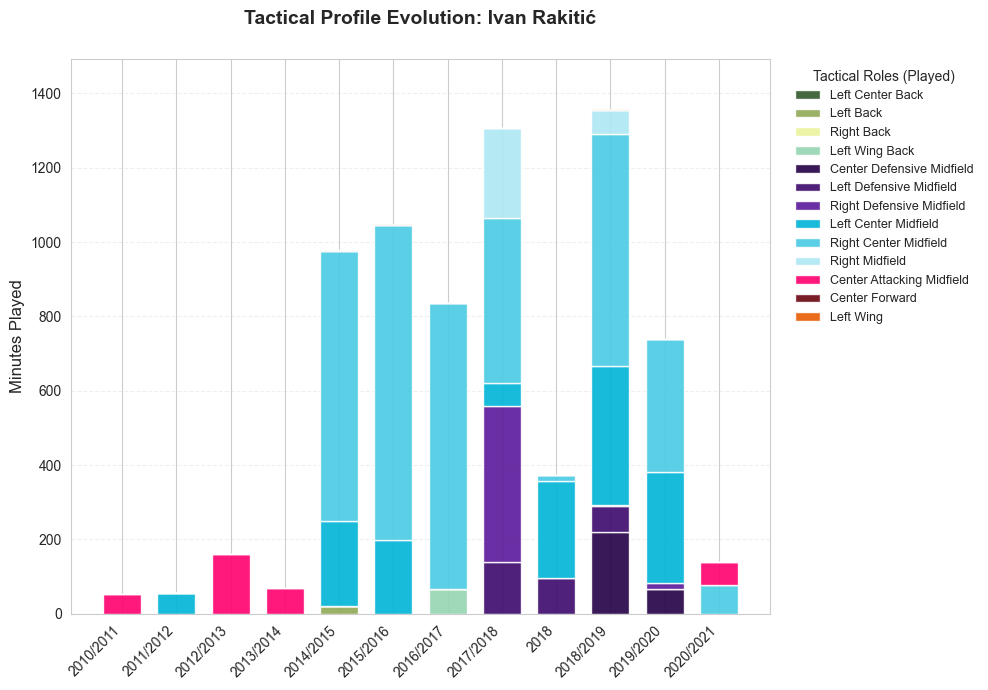

In [6]:
plot_player_versatility_gradient(STATSBOMB_DIR, "Ivan Rakitić")

#### The Case Study: Ivan Rakitić
Ivan Rakitić serves as a prime case study for structural displacement. His data reveals a high frequency of **"Tactical Plasticity,"** where he frequently vacillates between the **Center Midfield (Blue)** and **Center Defensive Midfield (Purple)** tiers. This was most evident in his transition from a creative fulcrum at Sevilla to the "Oxygen" of Barcelona’s midfield. In this role, his minutes-weighting shifted to provide Rest Defense—dropping into deeper pockets to stabilize the block while high-risk teammates pushed forward. This hybridity allows a player to manage a team’s equilibrium, acting as a structural insurance policy against transitions. Essentially, a significant portion of his "world-class" status comes not just from technical skill, but from this plasticity—the ability to maintain elite quality while shifting between two distinct tactical worlds.

The 2018 World Cup semi-final against England is the definitive example of this utility. Despite a 39°C fever, Rakitić managed a masterclass in **in-game re-tasking,** starting the match as a press-triggering **Center Midfield** before **"downshifting"** into a **Center Defensive Midfield** role to nullify England’s central access and settle the tempo. For a 2026 World Cup manager, this is the gold standard of Tournament Readiness. With an expanded 48-team schedule spanning three time zones, teams need **"Flow Operators"** who can bridge multiple tactical families. Rakitić proves that the most valuable assets are those who can adapt their functional role to sustain a team's shape when the physical tank is empty.

### 1.5 360° Frame Data: Spatial Context & Coverage Limits

Statsbomb 360 provides a spatial snapshot of every player in the camera frame during an event, expanding the dataset from a single ball-action to a full contextual map of players. With over 15.5 million spatial records, it allows us to analyze line-breaking passes and defensive structure; the "hidden" tactical data that standard event logs miss.

#### Dataset at a Glance
- **15,584,040 frames**
- **Coverage:** Only 9.3% of matches (323/3,464)
- **Competitions:** Tournament-focused. UEFA Euro 100%, Women's Euro 95%, but only 10% Bundesliga. No La Liga/PL/Serie A coverage.
- **Temporal:** All 2020-2025, zero overlap with dense 2015-2016 period.
- **Frames:** 50% teammate, 6.6% actor, 2.3% keeper. All have location + visible area polygons.


  STATSBOMB: THREE SIXTY
Records: 15,584,040 | Events: 1,027,908 | Matches: 323

--- Spatial Distribution ---
X coords:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 1.558404e7 │
│ null_count ┆ 0.0        │
│ mean       ┆ 64.148598  │
│ std        ┆ 27.882666  │
│ min        ┆ -8.284931  │
│ 25%        ┆ 43.537132  │
│ 50%        ┆ 65.792419  │
│ 75%        ┆ 86.308243  │
│ max        ┆ 129.422791 │
└────────────┴────────────┘

Y coords:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 1.558404e7 │
│ null_count ┆ 0.0        │
│ mean       ┆ 40.017899  │
│ std        ┆ 18.380463  │
│ min        ┆ -36.000988 │
│ 25%        ┆ 26.842133  │
│ 50%        ┆ 40.025101  │
│ 75%        ┆ 53.186447  │
│ max        ┆ 117.531555 │
└────────────┴────────────┘


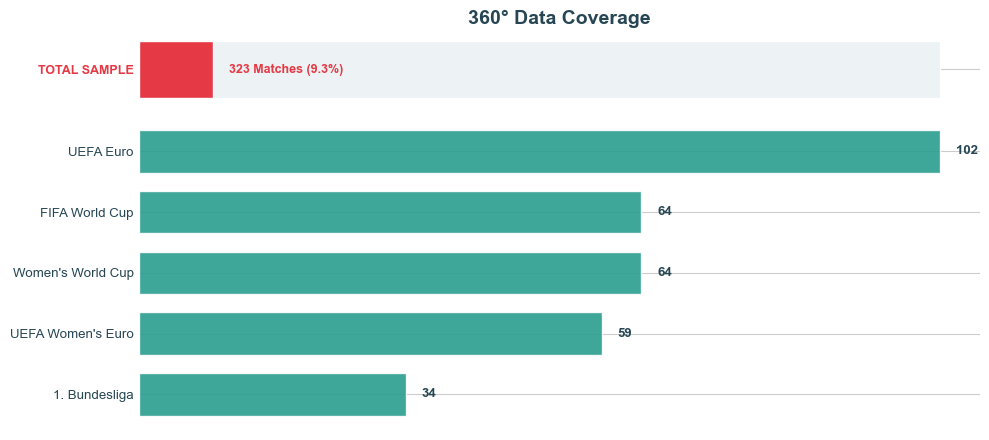

In [7]:
threesixty_results = safe_run(analyze_sb_360, "three_sixty")
plot_360_coverage_analysis(STATSBOMB_DIR)

#### Strategic Impact of 360° Data Coverage

The **limited 9.3% match coverage** (323/3,464) creates a disparity between our broad event dataset and high-fidelity spatial models. Because 360° data is exclusively tournament-focused and absent from major domestic leagues like La Liga or the Premier League, our ability to analyze defensive line-breaking passes and pressing geometry is restricted to elite international archetypes Furthermore, the zero overlap with the 2015–2016 era means we cannot conduct longitudinal studies on spatial evolution. Instead, we treat 360° frames as a calibration tool: we use this "Modern Gold Standard" to learn what elite spacing looks like today, then infer those tactical patterns across our larger historical event dataset.

Visualizing match ID: 3795108
Tracking points: 80,650
Saved: figures/360_heatmap.png


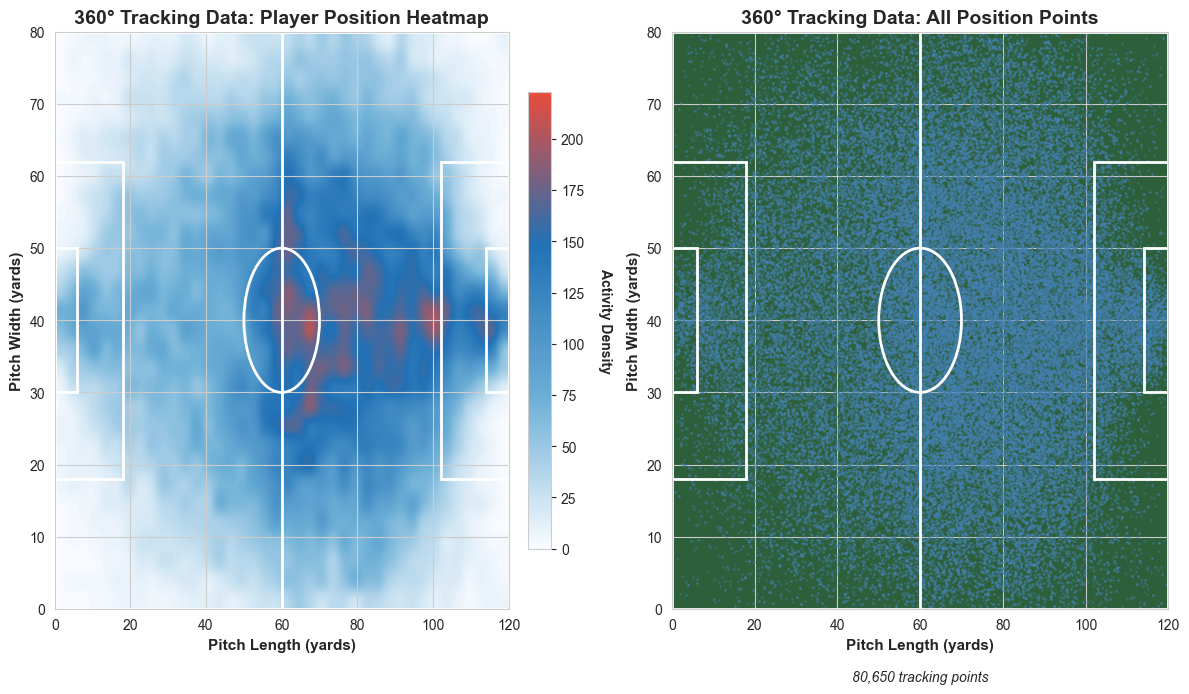

In [8]:
plot_360_player_heatmap(STATSBOMB_DIR)

#### What the 360° Data Shows
The 360° freeze-frame data captures the spatial position of every tracked player at the moment of each recorded event — not just what happened on the ball, but where everyone was off it. This is a fundamentally different class of data from standard event logs. The two panels above show a single match (80,650 tracking points), chosen as the most spatially complete example in the dataset.

The heatmap reveals what any football analyst would expect but rarely gets to measure directly: the central midfield corridor is the dominant activity zone, confirming that the majority of tactical contest happens between the two penalty areas rather than in either box. The concentration toward the right channel of the attacking half reflects a specific team's offensive tendency in this match, an observation that standard pass or carry data would suggest but never confirm spatially. The scatter plot makes the coverage argument visually: 80,650 individual player positions from a single match provide more spatial context than entire seasons of basic event data. We can see not just what zones were active but which areas of the pitch were consistently empty; the wide defensive channels in particular, which tells us something about the defensive shape both teams held.

### 1.6 Reference
- **9,566 rows** in 6 lookup tables
- **Tables:** player (9,043), team (312), country (141), event_type (35), play_pattern (9), position (26)
- All ID columns unique. Five duplicate player names, four duplicate team names (different entities, same name).
- Team table has gender info (male/female), only populated extra_info field.

In [9]:
ref = safe_run(analyze_sb_reference_adv, "ref")


  STATSBOMB: REFERENCE

--- Entity Distribution ---
shape: (6, 2)
┌──────────────┬───────┐
│ table_name   ┆ count │
│ ---          ┆ ---   │
│ str          ┆ u32   │
╞══════════════╪═══════╡
│ player       ┆ 9043  │
│ team         ┆ 312   │
│ country      ┆ 141   │
│ event_type   ┆ 35    │
│ position     ┆ 26    │
│ play_pattern ┆ 9     │
└──────────────┴───────┘

Total records: 9,566 | Unique IDs: 9,437
Note: 129 ID collisions occur across different categories.

--- Entity Name Collisions ---
- Players: 5 duplicate names (different entities)
- Teams: 4 duplicate names (different entities)
shape: (5, 3)
┌────────────┬───────────────────────────┬──────────┐
│ table_name ┆ name                      ┆ id_count │
│ ---        ┆ ---                       ┆ ---      │
│ str        ┆ str                       ┆ u32      │
╞════════════╪═══════════════════════════╪══════════╡
│ team       ┆ Aston Villa               ┆ 2        │
│ player     ┆ Borja Fernández Fernández ┆ 2        │
│ team    

#### Identity Integrity and Metadata Grain

The reference data serves as a straightforward lookup for categorical entities, and a quick sanity check confirms the data is clean and ready for use. 

There are a few minor quirks to take note of. Exploration reveals that while identity integrity is maintained via unique IDs, the id column functions as a category-level namespace rather than a global primary key, as evidenced by 129 ID collisions across different entity types. There are five players and four teams sharing the same name. Nonetheless, these aren't major issues; they just mean we have to join data using both the ID and the category name to keep things tidy. 

## II. From Raw Events to Football Intelligence: Metric Engineering
The preliminary exploration of the Matches, Events, Lineups, and 360 data confirms that the foundational building blocks for a sophisticated narrative are present. However, raw data is merely potential; to convert these disparate tables into a cohesive 'football story,' we must move beyond simple counts. By aligning our processing pipeline with industry standards and high-performance practices, we can transform granular event logs into advanced metrics that capture the true nuance of the game. Our goal is to see what intelligence we can churn out by applying these professional frameworks to our refined dataset.

This section documents the metric engineering layer that bridges raw event logs and high-level tactical modeling. All metric computation is handled via DuckDB - an in-process analytical database that allows SQL-based aggregation directly over Parquet files without loading the full 12.2M row event dataset into memory. The entire pipeline is orchestrated through a single entry point, `run_metrics.py`, which executes all metric computations in sequence and writes the outputs to a structured `/processed` folder - one folder per scope, and one file per metric, ready for downstream consumption by the player quality engine and tactical clustering system. This keeps the pipeline efficient, reproducible, and auditable at every step.

#### Temporal Scope and Predictive Intent

To ensure the model remains relevant for predicting the 2026 World Cup, we have constrained our temporal scope to prioritize recency and tactical evolution.
- **Team-level tactical metrics (2022-2024):** Tactical clustering is performed exclusively on major tournament data from 2022 onwards. This ensures the identified archetypes reflect the current "meta" of international football—characterized by high-intensity pressing and sophisticated rest-defense structures, rather than outdated tactical eras. Eight dimensions aggregated at the match and tournament level, capturing collective behaviour across all phases of play. These feed the tactical archetype clustering.
- **Player-level quality metrics (2021-2025):** The player quality engine utilizes a rolling five-season window. This provides a sufficiently large sample size to determine consistency while ensuring that the "Football Intelligence" generated is based on the current peak performance of players likely to feature in the 2026 squads. Twelve dimensions aggregated across five seasons per player, capturing individual contribution across attacking, defensive, and build-up phases. These feed the player quality engine.

What follows is the full mathematical specification of each metric, with football rationale for every design decision.

### 2.1 Team-Level Tactical Metrics Definition

#### Defensive Identity & Pressure

| Metric | Definition | Interpretation | Why This Metric |
|--------|-----|----------------|---------|
|**PPDA**<br>*(Pressing Intensity)* | Opponent passes allowed per defensive action in the opponent's attacking 60% — the industry standard pressing intensity measure | • **6–10:** Aggressive, suffocating press<br>• **15–20+:** Low block, passive defence (~18 for deep-defending sides) | Directly quantifies how aggressively a team hunts the ball in advanced areas. Cannot be inferred from possession or pass data alone. |
|**Defensive Line Height**<br>*(Defensive Positioning)* | Weighted average of defensive action locations across three pitch thirds: 1 for defensive, 2 for middle, 3 for attacking | • **1.0–1.5:** Deep block, defends in own box<br>• **2.0–3.0:** High line, presses high up the pitch<br>| Complements PPDA. Together they define the full defensive identity, where the team defends and how actively they contest the ball in those zones.|

This pairing defines a team's Defensive Geometry by simultaneously measuring the location and the intensity of their out-of-possession work. While Defensive Line Height establishes the "territory" (where the block sits on the pitch), PPDA quantifies the "aggression" (how actively they contest the opponent’s build-up). By analyzing these metrics in tandem, we can distinguish between a proactive high press (squeezing the pitch to hunt the ball) and a passive deep block (conceding space to prioritize structural compactness), providing a complete signature of a team's defensive identity.

**Calculation Reference**

```
PPDA = opponent_passes (x > 48) / defensive_actions (x > 48)
defensive actions = tackles + interceptions + fouls + duels

Defensive Line Height = (def_third×1 + mid_third×2 + att_third×3) / total_actions
actions = tackles + interceptions + blocks + clearances
```
#### Territory & Control

| Metric | Definition | Interpretation | Why This Metric |
|--------|-----|----------------|---------|
|**Field Tilt** <br>*(Territorial Dominance)* | Percentage of all actions (passes, carries, shots, dribbles) occurring in the opponent's final third | • **35%+:** Territorial dominance — pins opponent in their box<br> • **< 25%:** Territorial concession — typical of deep-block or counter-attacking systems.<br>| Separates territorial control from raw ball retention. It identifies whether a team's possession is functionally aggressive or merely defensive, providing a more accurate measure of dominance than pass completion rates alone.<br>*Note: High possession with low tilt indicates "sterile" circulation in one's own half.*|
|**Possession %** <br>*(Ball Control)* | Team passes as a share of total match passes — the industry standard possession proxy | • **55%+:** Possession-dominant, controls tempo <br>• **< 45%:** Counter-attacking, cedes the ball | Foundation metric. Establishes the team's baseline approach to controlling the game, a context for interpreting all other dimensions. |
|**Progressive Carry %** <br>*(Progression Style)* | Share of progressive actions that are carries rather than passes — distinguishes individual from collective progression | • **40%+:** Dribble-heavy, individual progression<br>• **< 25%:** Pass-heavy, collective progression | Identifies the team's primary method of ball progression. It captures the stylistic nuance of how territory is gained, distinguishing between teams that penetrate through individual dribbling and those that utilize structured passing combinations. |

The interplay between Possession % and Field Tilt reveals the difference between ball retention and true territorial dominance. While possession establishes who is controlling the tempo, Field Tilt indicates where that control is being exerted, allowing us to identify 'sterile possession'; where a team keeps the ball in non-threatening areas without penetrating the final third. When mapped alongside EPR (Efficiency), these metrics define whether a team’s dominance is being converted into genuine attacking threat or merely used as a defensive tool to deny the opponent the ball.

**Calculation Reference**
```
Field Tilt = (actions where x > 80 / total_actions) × 100

Possession % = (team_passes / total_match_passes) × 100

Progressive Carry % = (progressive_carries / (progressive_carries + progressive_passes)) × 100
```

#### Attacking Efficiency & Threat

| Metric | Definition | Interpretation | Why This Metric |
|--------|-----|----------------|---------|
|**EPR** <br>*(Possession Efficiency)* | Possession percentage divided by xG created — how much ball does the team need per unit of attacking threat | • **< 20:** Clinical/direct: creates xG with minimal possession<br> • **> 40:** Patient build-up: needs lots of possession per chance <br> | Provides context to ball retention by measuring the "Return on Investment" for possession. It helps distinguish between purposeful control and possession used primarily for defensive stability. |
|**npxG** <br>*(Attacking Threat)* | Sum of shot xG excluding penalties; open-play attacking quality only | • **1.8+:** Elite attack <br>• **< 1.2:** Struggles to create<br>| Focuses on the repeatable quality of open-play and set-piece creation. By removing penalties, we isolate the team's ability to create high-value chances through tactical play rather than refereeing decisions. |
|**xG per Buildup Possession** <br>*(Build-up Quality)* | Average xG created per multi-player build-up possession, excludes individual actions where only the shooter or assister touched the ball | • **0.15+:** Multi-player build-up creates high-quality chances<br>• **< 0.10:** Relying on individual moments or transition play | Highlights the effectiveness of a team's structured passing patterns. It differentiates between teams that systematically break down opponents and those that rely on a single player's individual brilliance. |

These metrics bridge the gap between offensive output and tactical process by quantifying both the volume and the source of a team's threat. While npxG establishes the baseline for open-play quality, EPR and xG per Buildup reveal the efficiency of the system, distinguishing between teams that create through high-volume possession and those that rely on clinical, structured passing patterns. Together, they provide a multi-dimensional view of attacking performance that separates repeatable team tactics from isolated moments of individual talent.

**Calculation Reference**
```
EPR = possession_pct / npxG
[NaN where xG = 0 — sterile possession]

npxG = Σ shot_statsbomb_xg  [excluding penalty shots]

xG per Buildup Possession = total_xg_buildup / buildup_possessions
[excludes possessions where only shooter/assister touched ball]
```

In [10]:
metrics = load_tournament_data_8d('men_tourn_2022_24', verbose=False)

### Distribution of Core Metrics

Saved: figures/team_metric_violins.png


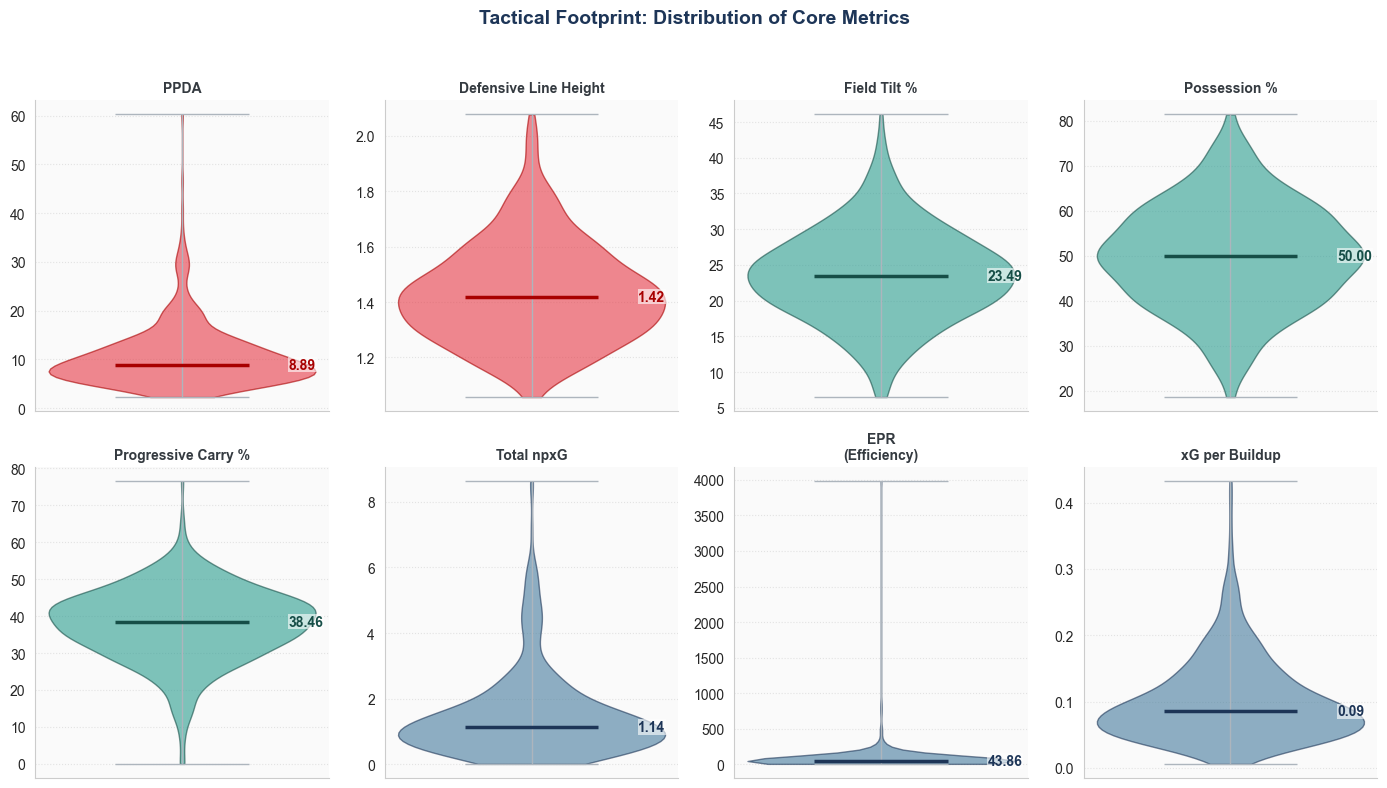

In [11]:
plot_metric_distributions(metrics)

#### What Do the Distributions Reveal?
The violin plots act as a "tactical fingerprint" of the current international era. The data reveals a game that has moved away from the "average" middle ground:

- **The Intensity Bipolarity (PPDA):** The median 8.89 reflects the high-intensity pressing of the 2022–2024 cycle (e.g., Austria/Germany). However, the long "right tail" stretching to 60 shows that the "mid-block" is dying; teams now choose to either squeeze the pitch or "park the bus" in deep, passive structures to survive knockout rounds.

- **The "Possession Trap" (EPR):** While Possession % is beautifully symmetric, confirming a healthy data pipeline, EPR shows extreme "sterile" outliers. This captures a uniquely modern struggle: teams like 2022 Spain holding massive possession (right tail toward 4000) but failing to penetrate, creating the "high volume, zero threat" profile.

- **Structural Realism (xG per Buildup):** The distribution is heavily right-skewed and tightly clustered near zero. This is a realistic reflection of the 2020s meta: scoring through multi-player passing sequences is incredibly difficult. Only a tiny elite "escapes" the cluster, making this metric the ultimate filter for identifying genuine 2026 title contenders.

- **Style Over Volume (Carry %):** Visually, the Carry % violin does not mirror the Possession violin. This confirms that line-breaking carries (the "Bellingham/Musiala profile") are a deliberate tactical choice rather than just a byproduct of having the ball. It allows us to distinguish between "rhythmic passers" and "vertical carriers."

This 2022-2024 metrics captures the "End of Neutrality" in international football. Tactical reports from recent tournaments highlight a move away from passive mid-blocks toward extreme defensive stances. Our metrics capture this shift: the PPDA tail represents the "Low-Block" specialists, while the Carry % and EPR metrics capture the modern struggle to break down those very structures through either individual brilliance or collective efficiency.

#### Implications for Clustering & Machine Learning

These visual findings dictate how we configure the machine learning model in the subsequent phase: 

- **Scaling and Outlier Mitigation:** The metrics live on completely different scales (PPDA 5-60 vs. Buildup 0-0.4). While a `StandardScaler` handles this, we must cap EPR at 200 first. Without this, the "sterile possession" outliers would mathematically crush the variation in more meaningful metrics.

- **Primary vs. Secondary Drivers:** Defensive Line Height and Possession have the widest, most uniform distributions. They will act as the "gravity" of the model, driving the primary split between proactive and reactive teams. Tightly clustered metrics like Line Height and Buildup Quality will then provide the "fine-tuning" to separate structured teams from direct ones.

- **Leveraging Independence (Orthogonality):** Metrics like EPR and Carry % are "independent" — they provide new information that Possession volume lacks. This allows the model to split "tactical twins" (teams with identical possession) into different archetypes based on their efficiency and method of progression.

### 2.1.2 Inter-Metric Correlation & Tactical Independence

Saved: figures/team_metrics_corr.png


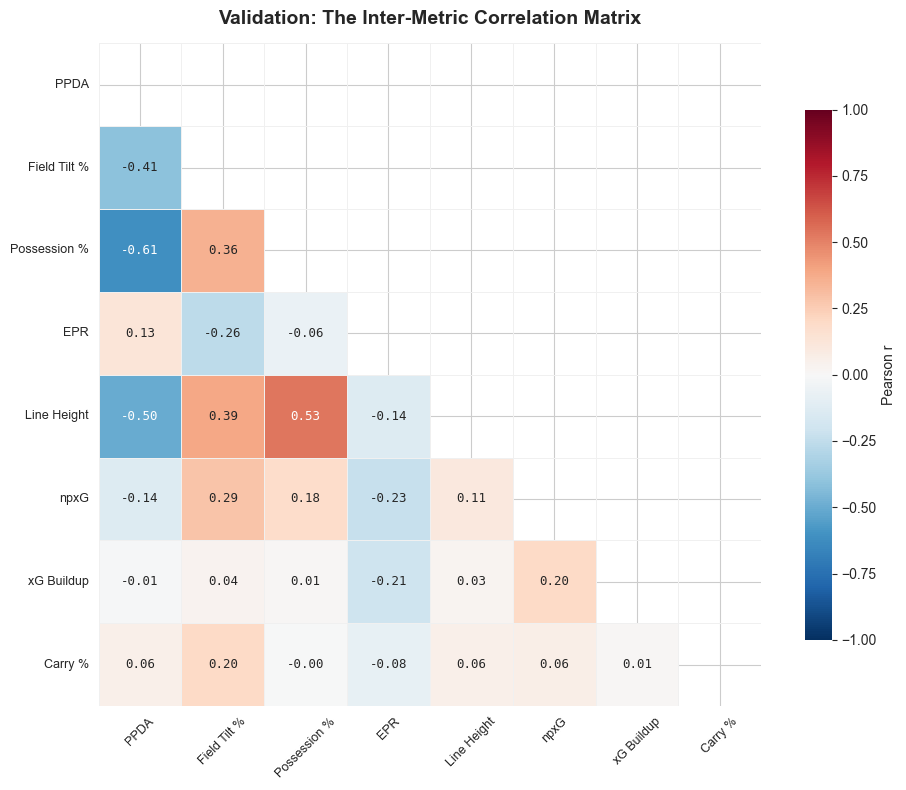

In [12]:
plot_correlation_matrix(metrics)

#### What Does the Correlation Matrix Reveal? 

- **The High-Press/High-Control Axis:** The strongest correlation in the dataset is between PPDA and Possession % (-0.61). This confirms a logical "Press-to-Possess" axis: teams that squeeze the pitch with high intensity tend to win the ball back more often and dominate possession. However, since they only share ~37% of their variance, a team can still be a "high-presser" without being "possession-heavy" (e.g., transition specialists).

- **Efficiency is an Independent Skill:** EPR is essentially uncorrelated with all other metrics, peaking at a negligible 0.13 with PPDA. This confirms that possession efficiency has nothing to do with possession volume. This is the mathematical "trap" for teams; you can dominate the ball (High Possession) but be completely ineffective at creating threat (High EPR).

- **Stylistic Progression:** Carry % and xG Buildup are the most "orthogonal" (independent) metrics in the set. Carry % shows a near-zero correlation with Possession (-0.00). This proves that how a team moves the ball, whether through individual carries or collective passing, is a stylistic choice that is not dictated by how much of the ball they have.

#### Implications for Clustering & Machine Learning

- **PCA Engine:** We expect the first Principal Component (PCA) to be defined by the PPDA/Possession/Line Height axis, as these metrics show the strongest logical and mathematical links. This will separate the "Proactive" teams from the "Reactive" ones.

- **Separating "Tactical Twins":** Because EPR and Carry % are independent of the main axis, they would act as the "Z-axis" in clustering. They allow the k-means algorithm to split teams that look identical on a simple possession chart into two different archetypes based on their efficiency and method of progression.

- **Feature Robustness:** With the highest correlation at only 0.61, every dimension is bringing "new news" to the table. This justifies the 8-metric framework over a simpler approach; we are feeding the model a richer, non-redundant set of features.

### 2.1.3 Tactical Identity vs. Tournament Depth: Decoding the "Winner Zone"

Now we move from verifying that our metrics are "correct" to proving they are predictive. By plotting tactical intent (PPDA × Possession) against output (npxG) and outcome (Tournament Depth), a clear blueprint for modern international success emerges.

Saved: figures/tactical_scatter.png


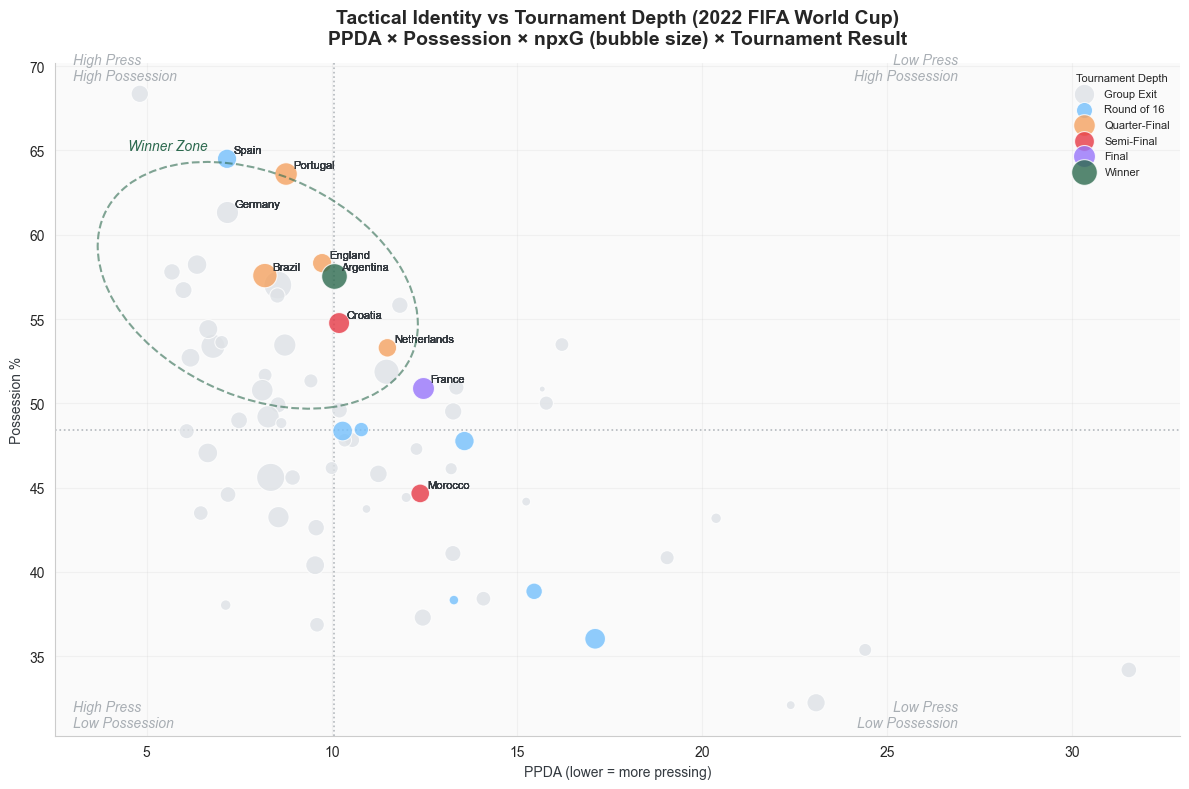

In [13]:
plot_tactical_scatter(metrics)

#### What Do We See in the Scatter Plot? 
- **The Empirical "Winner Zone":** There is a clear density of deep tournament runs (orange, red, purple, and green bubbles) in the top-left quadrant. Argentina (Winner) and Spain (R16 but tactical twin) both sit firmly inside the high-possession (58-64%), aggressive-pressing (PPDA 6-10) ellipse. This confirms that "winning football" in the 2020s is defined by proactive, high-territory dominance.

- **The Gradient of Success:** Success correlates strongly with movement toward the top-left corner. Group stage exits (grey bubbles) are scattered across the board but concentrate heavily in the bottom-right, defined by low possession and passive, low-intensity defending.

- **The Pragmatic Outlier (France):** France reached the final (purple) from a position firmly outside the winner zone, maintaining only ~51% possession and a passive ~13 PPDA. Their large bubble size indicates they created high xG without collective dominance, relying instead on individual "moments". This validates the need for our "Star Reliance" metric; France's success is explained by elite personnel rather than a dominant system.

- **The Underperformers (Portugal & Germany):** Both teams sit inside or near the "Winner Zone" with high possession and aggressive pressing, yet exited prematurely. This highlights the "floor vs. ceiling" problem—the metrics capture a high-functioning tactical system, but they cannot account for variance in finishing or clinical errors on the day.

#### Implications for Clustering & Machine Learning
- **Validating the Primary Axis:** The diagonal split from top-left to bottom-right confirms our earlier observation from the correlation matrix: PPDA and Possession are the "engines" of tactical identity. This axis will be the primary driver of our k-means cluster separation.

- **A "Pragmatic" Cluster is Required:** The distance between France/Morocco and the Argentina/Spain group proves we need enough clusters (k=4) to distinguish between "Dominant Proactives" and "Elite Pragmatists". A simple k=2 model would incorrectly group France with the tournament's "also-rans" simply because they don't press high.

- **Defining the "Elite" Threshold:** The bubble size (npxG) acts as the ultimate quality filter. While many teams can mirror the shape of a winner (high possession), very few can mirror the volume of the winner (large bubbles). Our clustering must treat xG-based metrics as the "quality" differentiator within tactical groups.

### 2.1.4 Does Tactical Identity Predict Outcomes?
To move from tactical theory to competitive reality, we must test if these quadrants actually translate to winning. By splitting the 2022 World Cup and Euro 2024 dataset based on median tactical values, we can calculate the win, draw, and loss rates for each identity. This provides a reality check on which tactical profiles actually translate into match-day results. While the scatter plot predicts tournament depth, the quadrant analysis validates tactical identity at the individual match level.

Saved: figures/team_outcome_by_quadrant.png


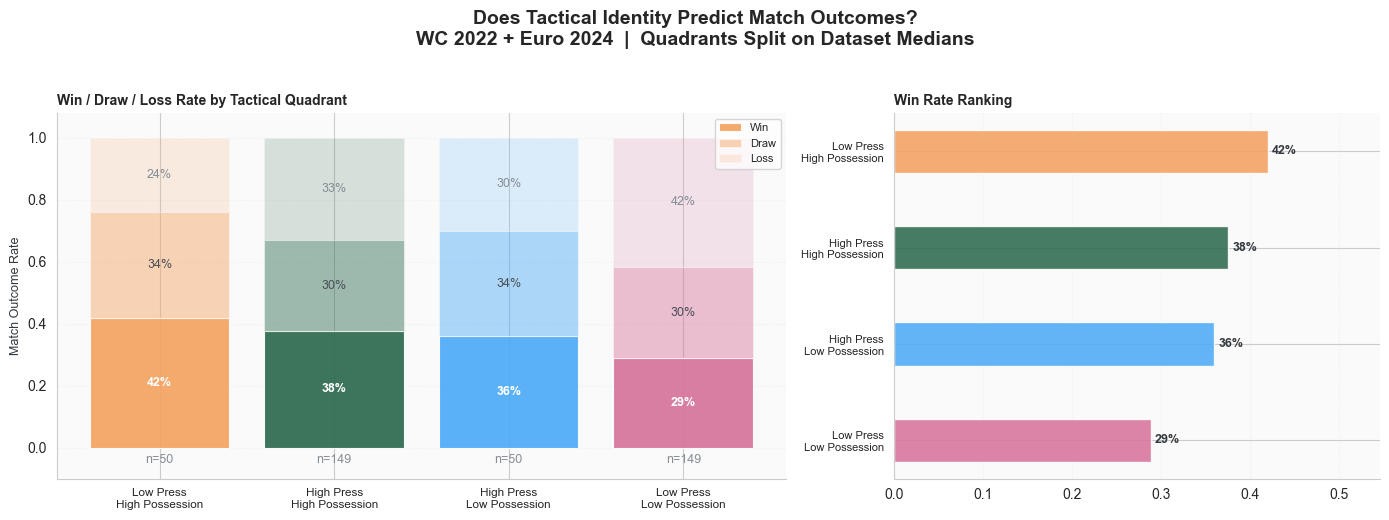

In [14]:
plot_outcome_by_quadrant(metrics, STATSBOMB_DIR)

#### What Does the Quadrant Chart Reveal?
- **The Rare Efficiency of "Patient Control" (Low Press / High Possession):** The headline finding is counterintuitive: this quadrant wins 42% of matches, the highest of any group. However, the n=50 sample size is the key. This isn't a "magic formula"; it is a selective sample of technically superior teams (like Argentina or Portugal) playing patient football against outclassed opponents. They don't need to "hunt" for the ball because they never lose it.

- **The "Mainstream Meta" (High Press / High Possession):** With the largest sample size (n=149), this quadrant represents the modern elite standard. Its 38% win rate is robust but slightly lower than the patient controllers because it includes every heavyweight "dogfight" where two high-pressing giants cancel each other out.
- **The Futility of the "Passive Bus" (Low Press / Low Possession):** At a 29% win rate, this is the least viable strategy. Passive defending combined with ceding the ball results in a win rate that is nearly a coin flip. It validates the framework—simply "parking the bus" without a transition threat is statistically the fastest way to an early exit.
- **The "Chaos" Tax (High Press / Low Possession):** High pressing without the quality to sustain possession results in a 36% win rate. While physically imposing, this "Vertical Disruptor" profile is exhausting; teams work hard to win the ball but lack the technical composure to convert those turnovers into goals consistently over 90 minutes.

#### Match Outcome vs. Tournament Depth

While these match-level win rates validate the tactical framework, they come with a crucial caveat: winning matches is not the same as winning tournaments. A team can win 60% of matches and still exit early if they lose the one that matters. The scatter plot (tournament depth) is the more valid predictor of what we actually care about, while the quadrant chart validates tactical identity at the individual match level; which is a different and complementary finding.

### 2.1.5 The Tactical Fingerprint: Global Convergence vs. Regional Alpha
Standard normalization often masks the true competitive differences between tournaments. To satisfy a more rigorous tactical inquiry, the Z-Score Radar centers on the Global Population Mean (0.5) and scales axes by Standard Deviation (σ) to expose the "Tactical Tilt" of each tournament.

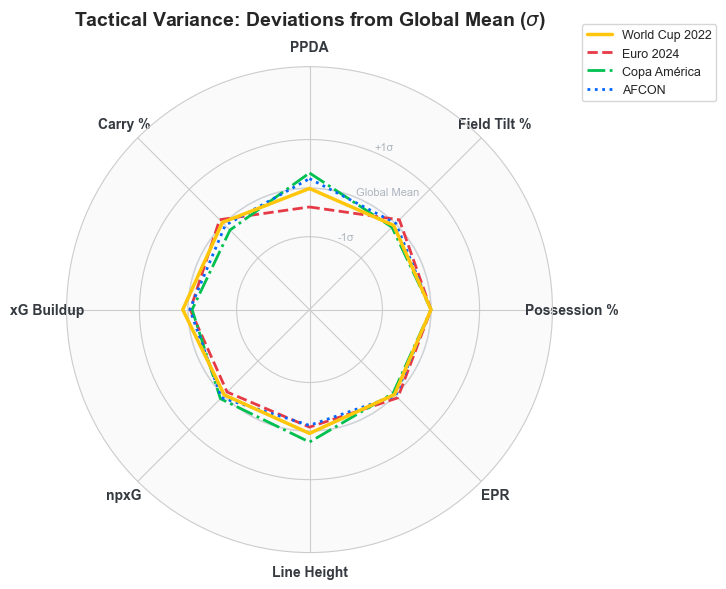

In [15]:
plot_competition_radar(metrics, STATSBOMB_DIR)

#### What Does the Radar Chart Reveal?
The overlapping profiles in this final chart provide the "License to Pool" for the model. It demonstrates that WC 2022, Euro 2024, Copa América, and AFCON are tactically comparable environments, making their combination for clustering statistically defensible rather than just a convenience.

- **PPDA is the biggest divergence:** This is the metric where the tournaments separate most clearly. Copa América (green) and AFCON (blue) push furthest outward, indicating a significantly higher pressing intensity (lower PPDA) compared to the Euro 2024 (red) and World Cup 2022 (yellow) averages.

- **Possession % is the tightest convergence:** All four lines overlap almost perfectly at the Possession % axis. This suggests that ball control volume has become a global constant at the international level.

#### Implication for Clustering & Machine Learning
This convergence captures the globalization of football coaching. Because the tournament averages are nearly identical, the subsequent clustering will be driven entirely by within-tournament team variance rather than between-tournament confederation effects. This ensures the archetypes are genuine tactical identities rather than confederation labels in disguise.

### 2.1.6 Tactical Consistency: Mapping Match-to-Match Volatility
While the competition radars confirm a global convergence in tactical averages, the Tactical Consistency analysis reveals how individual nations deviate from their own identities across different matches. By plotting the standard deviation of PPDA (Pressing consistency) against the standard deviation of Possession % (Possession consistency), we can categorize the 2026 World Cup contenders into four distinct quadrants.

Saved: figures/tactical_consistency.png


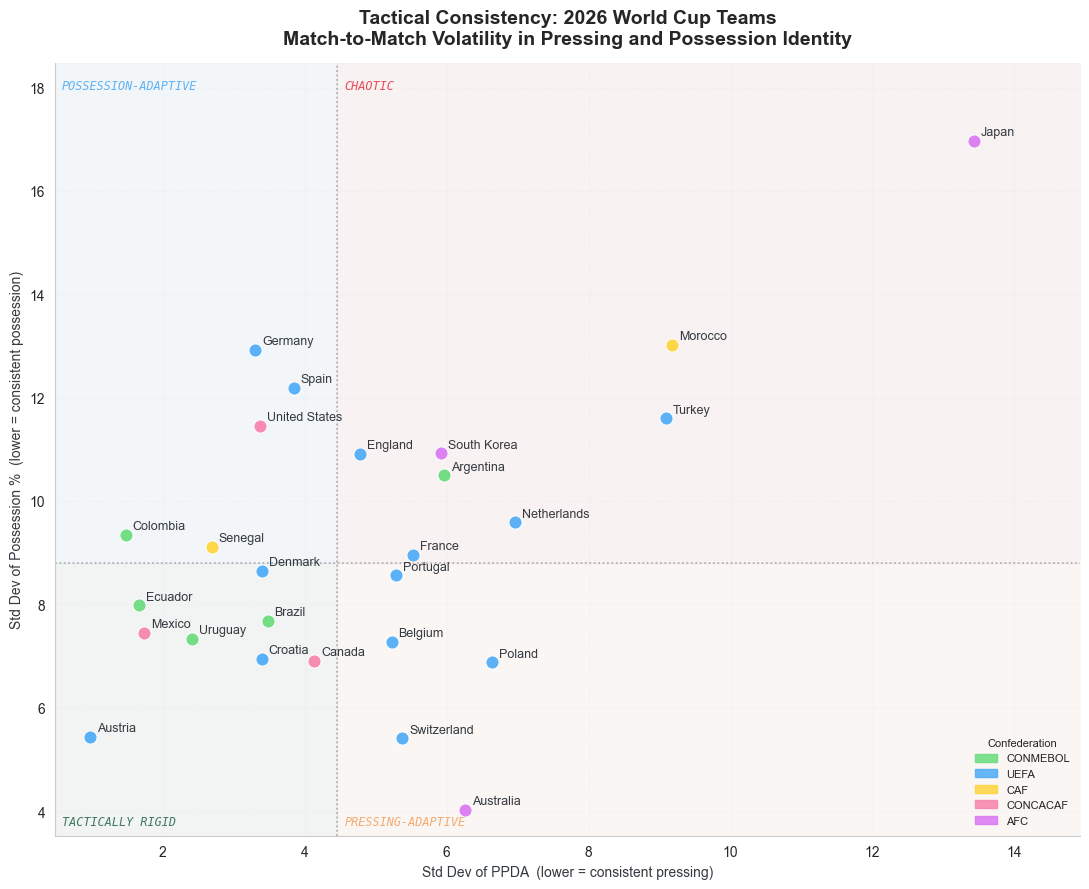

In [16]:
plot_tactical_consistency_scatter(metrics, min_matches=3)

#### The CONMEBOL Cluster: A Standout Finding
The most significant discovery is the clustering of Colombia, Ecuador, Uruguay, and Mexico in the bottom-left "Tactically Rigid" quadrant.
- **The Professionalization of "La Nuestra":** These teams exhibit the lowest volatility in both pressing and possession across the entire dataset. This "Rigid" profile is the hallmark of the Bielsa (Uruguay) and Lorenzo (Colombia) eras. They have replaced individual-driven chaos with highly synchronized, automated systems.
- **The 18-Round "Pressure Cooker":** This consistency is a survival mechanism. The grueling CONMEBOL qualification process—18 rounds against the same elite opponents—punishes tactical experimentation. To qualify for 2026, these teams had to develop a "Base Identity" that functions at the altitude of Quito, the heat of Barranquilla, and the intensity of Montevideo. Their signatures barely shift because their systems are battle-hardened.
- **The Mexico Connection:** Mexico’s presence in this cluster is the "smoking gun" for their recent tactical pivot. Under their current setup, El Tri has moved away from the erratic experimentation of previous cycles toward a "South Americanized" model—prioritizing a settled defensive block and consistent possession structures to match the physical demands of the 2026 host environment.

Despite being the reigning World Champions, **Argentina sits as a clear outlier,** positioned above the median for possession variance. This "Chaotic" label in the data is actually a badge of Tactical Superiority.

- **The "Scaloni Evolution":** Argentina has moved beyond a "system" to become a "chameleon." Our data captures how they dominated possession against mid-tier opposition in the 2025 qualifiers while being perfectly comfortable dropping to 40% possession to bait and destroy elite opponents on the break.
- **The Messi/Mac Allister Pivot:** Their pressing remains incredibly consistent (low PPDA variance), which provides the foundation for their success. However, their fluid possession variance is a sign of Tactical Maturity—they use the ball as a tool for control in some matches and as a weapon for transition in others. They are the only CONMEBOL side with the technical depth to be "Tactically Unpredictable" without losing their defensive shape.

#### The Possession-Adaptive Heavyweights: Germany and Spain
Unexpectedly, both Germany and Spain sit high on possession variance despite their reputations for dominance. This is not a sign of weakness, but of strategic evolution in response to the modern international "meta."
- **Germany’s "Chaos-Control" Hybrid:** Germany’s position reflects the finalized Nagelsmann transition. After a "bumpy" start to the 2025 qualifiers (including a shock loss to Slovakia), Nagelsmann moved away from a static possession model. The high variance now captures a team that oscillates between extreme high-possession build-up (anchored by Pavlovic and Kimmich) and a "maniacal" direct counter-pressing style. They are deliberately unpredictable, choosing to "suffer" without the ball in order to create higher-quality transition moments for Wirtz and Musiala.
- **Spain’s Vertical Evolution:** Under Luis de la Fuente, the reigning European champions have officially buried the "tiki-taka" dogma. Their high possession variance is the mathematical signature of a team that is now comfortable being direct. While they still recorded a "symphony" of a 66-touch goal against Turkey in 2025, they often drop their possession significantly against elite peers to unleash the verticality of Lamine Yamal and Nico Williams. For the first time in two decades, Spain’s tactical success is defined by contextual efficiency rather than possession volume.
- **The Tactical "Iberian" Blend:** Both teams are now utilizing what analysts in 2026 call "Tactical Bilinguality." They can speak the language of dominant possession, but they are increasingly choosing to speak the language of the transition. This results in the high standard deviations seen in our chart — they aren't "inconsistent"; they are simply the most versatile teams in the tournament.

#### The "Chaotic" Quadrant: Morocco and Turkey
Both nations show high volatility across both pressing and possession, but for different underlying reasons.
- **Morocco (Contextual Mastery):** Morocco’s high variance is driven by a defensive masterclass against elite sides (Portugal) versus dominant performances against peers (Canada).
- **Turkey (Intensity Shifts):** Their Euro 2024 data captures a team that radically adjusted pressing intensity match-to-match—aggressive against Georgia, yet passive against Portugal.

#### The Systematic Benchmark of UEFA: Austria
UEFA shows the widest diversity, with teams scattered across all four quadrants, reflecting a vast array of tactical identities. Austria stands out as the most interesting European finding, located in the bottom-left "Tactically Rigid" quadrant with the lowest possession variance in Europe.
- **The Rangnick Identity:** Rangnick's system is the most identifiable tactical brand in Europe right now, leading Austria into this World Cup with a squad that functions like a high-intensity club side. He implements a systematic gegenpressing system with the same intensity regardless of the opponent. Austria consistently accept lower possession in exchange for high-pressing disruption, making them the most identifiable tactical unit in Europe.

#### The Pragmatic Median: France and Portugal
Both nations sit near the center of the axes, representing a pragmatic "heavyweight" profile. **Didier Deschamps (France)** and **Roberto Martínez (Portugal)** both occupy the center of the volatility chart, reflecting a shared philosophy of prioritizing game states and opponent-specific threats over a fixed tactical identity.
- **The Deschamps Farewell:** As he prepares to step down following this 2026 World Cup, Deschamps remains the benchmark for this profile. France’s position near the median validates his career-long commitment to "winning the match at hand" rather than imposing a dogmatic style, a pragmatism that has kept France at the global summit for over a decade.
- **The Martínez Modernization:** Roberto Martínez has successfully implemented a similar "low-floor, high-ceiling" pragmatism with Portugal. By moving away from the rigid patterns of the previous era, he has modernized their transition game into a fluid, context-heavy system. His data signature confirms a visionary approach: a flexible blueprint that values collective responsibility and tactical innovation over isolated star power, allowing Portugal to pivot seamlessly between control and counter-attack depending on the tournament stage.

The lack of a unified tactical culture across the Asia-Pacific confederation is highlighted by Australia and South Korea sitting in opposite quadrants, while the 2026 hosts (USA, Mexico, and Canada) are split between the "Tactically Rigid" and "Possession-Adaptive" sectors, showcasing the divergent coaching philosophies currently at play across the CONCACAF region.

### 2.1.7 What the Data Tells Us Before We Model

The exploratory analysis has done more than describe the data — it has stress-tested the methodology before a single model is trained. The eight tactical dimensions are statistically non-redundant, football-credible in their team rankings, and collectively predictive of tournament outcomes. Furthermore, the analysis confirms that the four competitions are tactically equivalent enough to pool without confederation bias. The consistency analysis has already identified which teams carry a clear tactical identity into 2026 and which are context-dependent adapters, a distinction that will surface again in the clustering results.

Three findings in particular carry forward into everything that follows:

- **Multidimensionality of Success:** No single dimension explains tournament success. It is the sophisticated combination of pressing intensity, possession efficiency, and build-up quality together that separates deep runs from early exits. This justifies the 8-dimension clustering framework over a simpler, linear ranking approach.
- **The Managerial Context:** It is worth noting that tactical metrics often act as a secondary mirror for managerial temperament. While the data gives us the "what," the managers give us the "why." Whether it’s the high-consistency systems of a Bielsa (Uruguay) and Rangnick (Austria) or the more reactive, "game-solver" approach of Deschamps (France) and Scaloni (Argentina), we have to acknowledge that some of the variance in our data is just human personality in action. It’s a dimension that doesn't replace the model, but it certainly helps us read the room as we head into 2026.
- **The "Tactical Gap":** Tactical identity alone is insufficient. Both Morocco and France demonstrate that cohesion, defensive organization, and individual star quality explain outcomes that collective tactical metrics cannot fully capture. This is precisely the gap that the Player Quality Engine, built next, is designed to fill.

### 2.2 Player Quality Metrics

#### The Offensive Engine - Direct Output & Threat
| Metric | Definition | Interpretation | Why This Metric |
|--------|-----|----------------|---------|
| **Goals − xG**<br>*(Finishing Quality)* | How much a player over- or under-performs their expected goals. A proxy for clinical finishing quality | • **High+3+:** Converts low-probability chances <br>• **±1:** Finishing as expected<br>• **−3+:** Wasteful relative to chances created<br>| Raw goal counts are often deceptive as they don't account for the difficulty of the chance; this residual isolates pure finishing skill from the quality of the service provided. It allows the model to identify "game-breakers" who can produce a result out of nothing during tight knockout fixtures. |
| **Progressive Passes p90** | Completed passes advancing the ball ≥10 yards forward or into the penalty area — open play only, middle and attacking third | • **8+:** Elite playmaker<br>• **< 4:** Limited passing threat| Football is ultimately a game of territory, and this metric separates the ambitious playmakers from those who simply recycle possession sideways. It identifies which players have the vision and technical bravery to actively dismantle an opponent's defensive block. |
| **Team Involvement %** | Player's share of their team's total attacking threat. Identifies talismanic dependency | • **25%+:** Talismanic<br>• **15–25%:** Key attacking player<br>• **8–15%:** Regular contributor<br>• **< 8%:** Peripheral | By looking at the relative share of output rather than just the volume, we can identify "Talismanic Dependency." This is crucial for the model to understand tactical risk—if a team is over-reliant on one player, their win probability drops significantly if that player is neutralized. |

These metrics act as a check-and-balance system: Team Involvement % tells us who the team looks for, while `Goals − xG` tells us if that reliance is being rewarded with clinical efficiency. When a player pair shows high Progressive Passing alongside high Team Involvement, it identifies a "Hub-and-Spoke" attack where one player dictates the entire territorial gain and outcome of the match.

**Calculation Reference**
```
Goals − xG = actual_goals − Σ(shot_xG)

Progressive Passes = (total_progressive_passes / minutes) × 90

Team Involvement % = (player_xg_chain / team_total_xg_chain) × 100
```

#### The Architects (Build-up & Progression)
| Metric | Definition | Interpretation | Why This Metric |
|--------|-----|----------------|---------|
| **Progressive Carries p90** | Ball carries advancing the ball forward meaningfully — distance threshold varies by pitch zone | • **6+:** Elite dribbler <br>• **< 3:** Rarely dribbles forward| While passing moves the ball, carrying moves the opposition; this metric identifies the "dribbling engines" who can break a tactical stalemate through individual athleticism and technical bravery. It allows the model to distinguish between a static playmaker and a mobile threat. |
| **Avg Packing per Pass** | Average opponents bypassed per progressive pass (requires 360° freeze-frame data) | • **4+:** Elite line-breaker <br>• **3–4:** Strong penetration<br>• **2–3:** Average<br>| Progressive pass counts tell us how often a player looks forward, but Packing tells us how effective those passes are at removing defenders from the game. It is the gold standard for measuring a player's true verticality and their ability to unlock a match. |
| **xG Chain p90** | Total attacking involvement — credits every player who touched the ball in a possession ending in a shot | • **0.8+:** Heavily involved <br>• **< 0.4:** Limited involvement| Traditional stats like goals and assists ignore the "architects" who do the heavy lifting early in a sequence; this metric ensures that deep-lying playmakers and influential wingers are properly valued for their total contribution to the team's offensive flow. |

The Architects group identifies how a team navigates the pitch. By comparing Progressive Carries against Packing, we can see if a team's progression is "Physical" (running through lines) or "Technical" (passing through lines). When a player scores highly in both, they become a Tactical Irreplaceable; a player who can solve defensive problems in multiple ways. xG Chain then ties it all together, ensuring that even if a player isn't the one scoring, we can see exactly how much "attacking value" would be lost if they were removed from the lineup.

**Calculation Reference**
```
Progressive Carries = (total_progressive_carries / minutes) × 90

Avg Packing = mean(opponents_bypassed) across all progressive passes
[requires 360° freeze-frame coordinates]

xG Chain p90 = (Σ xG_chain / minutes) × 90
```

#### The Structural Hubs (Build-up & Control)
| Metric | Definition | Interpretation | Why This Metric |
|--------|-----|----------------|---------|
| **xG Buildup p90** | Deep playmaking — same as xG Chain but excludes the shooter and assister, isolating pure build-up contribution | • **0.5+:** Elite deep playmaker <br>• **0.2-0.5:** Regular build-up contributor<br>• **< 0.2:** Minimal build-up role| This metric is essential for isolating the contribution of the "unsung heroes" from the finishers; it rewards players who do the difficult work of progressing play under pressure. It allows the model to value the structural stability provided by deep-lying midfielders who rarely appear on a standard scoresheet.|
| **Network Involvement %** | Player's centrality in the team's passing network — structural importance to build-up | • **18%+:** Hub/orchestrator <br>• **12-18%:** Key connector<br>• **8–12%:** Regular involvement<br>• **< 8%:** Peripheral | High-level football is a series of connections, and this metric identifies which players are structurally irreplaceable to a team's identity. If a "Hub" is marked out of a game, the entire build-up often collapses, making this a critical variable for the model when predicting how a team will handle high-pressure opposition.|

The Structural Hubs define the "spine" of the team. By pairing Network Involvement % with xG Buildup, we can see who isn't just touching the ball frequently, but who is doing something meaningful with those touches early in the sequence. When a player ranks highly in both, they represent the team's "Safety Valve" — the person teammates look for when under pressure. This group provides the context for the Architects and Engineers; without these hubs, the more explosive players further up the pitch would never receive the ball in the positions they need to succeed.

**Calculation Reference**
```
xG Buildup p90 = (Σ xG_buildup / minutes) × 90

Network Involvement = ((passes_made + passes_received) / team_total_passes) × 100
```

#### The Defensive Identity (Pressing & Protection)
| Metric | Definition | Interpretation | Why This Metric |
|--------|-----|----------------|---------|
| **High Turnover %** | Share of defensive actions in the attacking third. Measures pressing aggression and high-line positioning | • **40%+:** Hunts in final third <br>• **25-40%:** Moderate high pressing<br>• **< 25%:** Defends deeper| This metric provides the "geographic" context for a player's work; it allows the model to distinguish between an aggressive high-pressing forward and a traditional deep-lying center-back who might have similar raw action counts but vastly different tactical responsibilities. |
| **Pressure Success %** | Proportion of pressures resulting in the team winning the ball within 5 events | • **35%+:** Effective, wins ball consistently<br>• **25-35%:** Average<br>• **< 25%:** Chaotic — high volume, low return| Quality must be measured alongside quantity; without this percentage, a "chaotic" presser who runs a lot but achieves little looks identical to a disciplined, effective defender. It is the key to identifying players who possess true defensive "IQ." |
| **Pressures p90** | Volume of pressing events normalised to 90 minutes | • **18+:** Intense presser <br>• **12–18:** Active<br>• **8-12:** Moderate<br>• **< 8:** Passive/selective | Pressing is the primary defensive weapon in the modern meta, but volume without effectiveness is merely noise. Pairing this with Success % allows the model to see which players have the physical capacity to sustain a high-intensity game plan for a full tournament.|
| **Total Defensive Actions** | Volume of defensive contribution per match: tackles, interceptions, pressures, blocks, clearances, recoveries, duels won | • **18+:** Elite <br>• **12-18:** Strong contributor<br>• **6-12:** Moderate<br>• **< 6:** Limited| This serves as the baseline for a player's overall defensive activity. When used alongside High Turnover %, it gives the model a complete picture of not just how much a player defends, but where and how they influence the game out of possession.|


**Calculation Reference**
```
High Turnover % = (high_turnovers / total_defensive_actions) × 100

Pressure Success % = (pressure_regains / total_pressures) × 100

Pressures p90 = (total_pressures / minutes) × 90

Total Def. Actions = tackles + interceptions + pressures + blocks + clearances + recoveries + duels_won
```

### 2.2.1 Data Distribution & Coverage Analysis

Saved: figures/player_metrics_row_counts.png


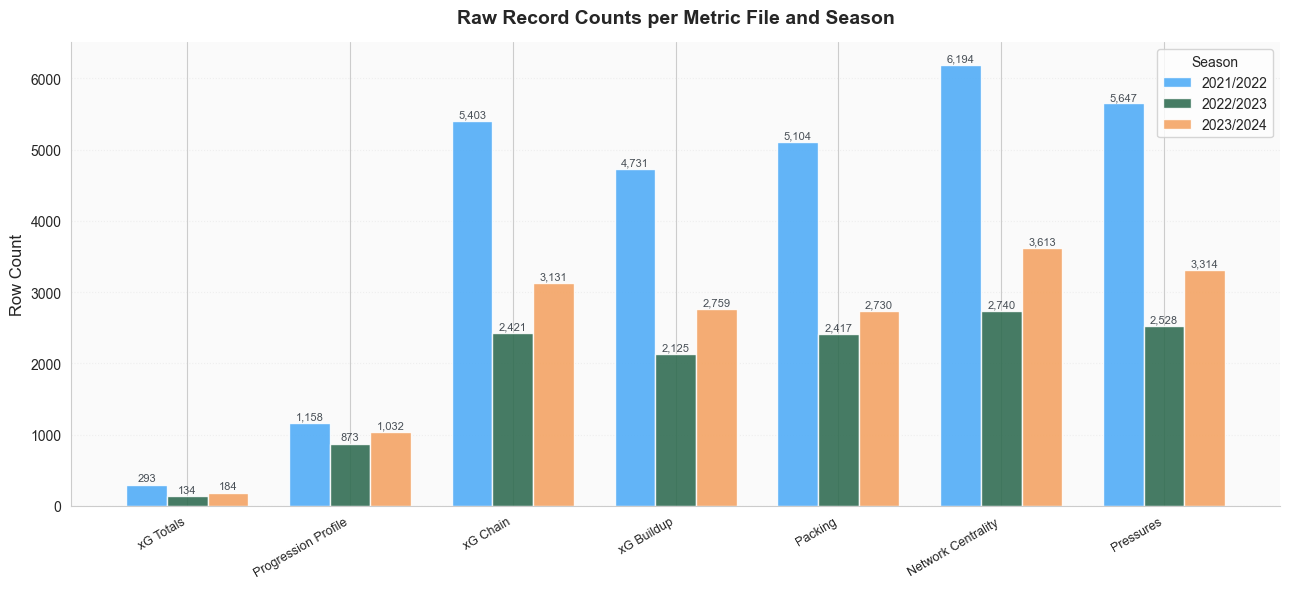

In [17]:
player_raw_data = load_all_players() 
plot_row_counts(player_raw_data)

#### What Does the Record Count Distribution Chart Reveal?
The record count distribution across the three-season window reveals a significant structural concentration in the 2021/2022 season, which dominates every metric file — most notably in Network Centrality (6,194 records) and Pressures (5,647 records). This volume is largely an artifact of StatsBomb’s historical coverage distribution, and the pattern directly validates the time decay architecture which we plan to implement within the scoring pipeline; by weighting the most voluminous season the least, the model ensures that historical coverage "noise" does not overwhelm the more predictive 2026 signals from the 2023/2024 window.

A primary challenge identified in the coverage profile is the extreme divergence in record counts between tactical dimensions:

- **The Finishing Gap:** xG Totals contains the thinnest coverage in the pipeline, with only 611 combined records across all three seasons. 

- **The Architects & Hubs:** Conversely, Network Centrality and xG Chain provide over 12,000 and 10,000 records respectively. 

- **The Packing Integration:** With the successful inclusion of Packing data, the "Architects" category now shows robust coverage, particularly in 2021/2022 (5,104 records), providing a critical link between deep build-up and final-third entry.

Saved: figures/coverage_heatmap.png


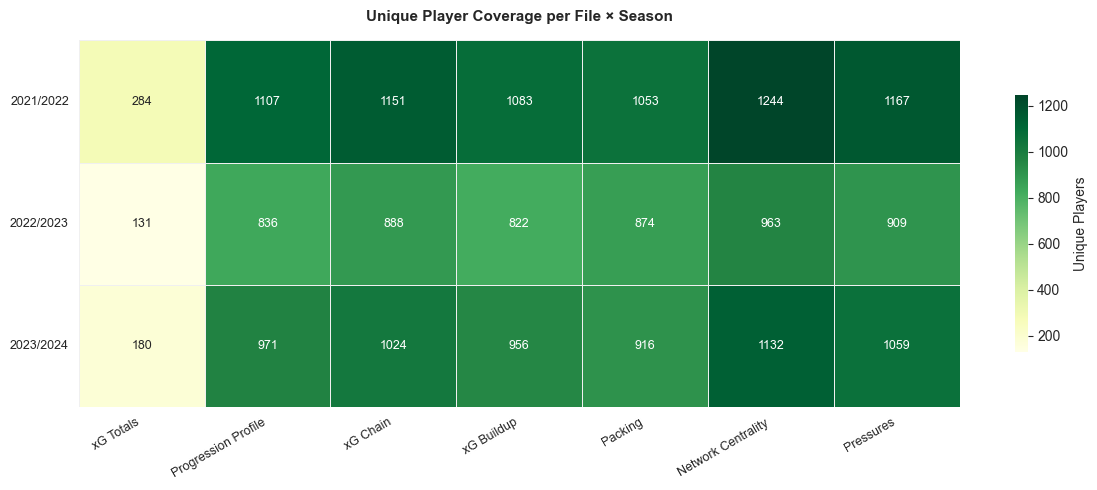

In [18]:
plot_coverage_heatmap(player_raw_data)

#### What Does the Player Coverage Heatmap Tell Us?
- **Data Sparsity and the Necessity of Bayesian Shrinkage:** The heatmap reveals a stark population hierarchy: while "Build-up" metrics like Network Centrality and xG Chain cover over 1,100 players, the xG Totals file captures fewer than 300 unique players per season. This indicates that for approximately 80% of our visible population, direct finishing data is missing. 

- **Addressing the 2022/2023 Coverage Contraction:** A uniform "dip" is visible across every single metric during the 2022/2023 season, where unique player counts drop by 25–35% compared to the surrounding years. Because this contraction is proportional across all files, we can conclude it is a structural data artifact rather than a change in footballing quality. 

- **Planning for Partial Profile Modularization:** The intersection of these files suggests that only a small elite group (roughly 100–200 players) will have a "Full Profile" across all seven dimensions. For the vast majority of our dataset, we are preparing for a Partial Profile scenario. This observation forces our future scoring pipeline to be modular; we must design the model to calculate a valid aggregate score even when specific dimensions, like the xG Totals or high-volume Pressures, are unavailable. 

#### Modeling Implications

The structural distribution of the data identifies three key requirements for the 2026 projection model:

- **Bayesian Shrinkage as a Structural Necessity:** The heatmap reveals that while build-up metrics cover over 1,100 players, xG Totals captures fewer than 300. This asymmetry makes Bayesian shrinkage mandatory; without it, players with tiny shot samples would carry the same statistical weight as high-volume strikers. Shrinkage will pull these sparse profiles toward positional means to prevent unreliable performance outliers.

- **Time-Decay to Counter Coverage Volatility:** A uniform 25-35% "dip" in unique players during the 2022/2023 season across all metrics confirms a structural dataset artifact. To maintain stability, the model will utilize a time-decay weighting, ensuring the more complete 2023/2024 data carries the primary predictive weight and prevents the 2022/2023 gap from biasing final scores.

- **Modular Pipeline for Partial Profiles:** Joining all available files restricts "Full Profiles" to an elite intersection of roughly 100-200 high-minute starters. Consequently, the model must be modular to score the majority of the population who present partial profiles. Using league tier multipliers and uncertainty inflation, the framework will treat these gaps as known boundary conditions rather than missing data.

- **Network Involvement as the "Data Anchor":** With the highest unique player counts and a bimodal distribution, Network Involvement % acts as the primary anchor for the 80% of players who lack shooting data. This metric allows the model to distinguish between "Structural Pillars" and "Peripheral Options" even when attacking output is sparse.

### 2.1.2 Distribution of Core Metrics

Saved: figures/metric_distributions.png


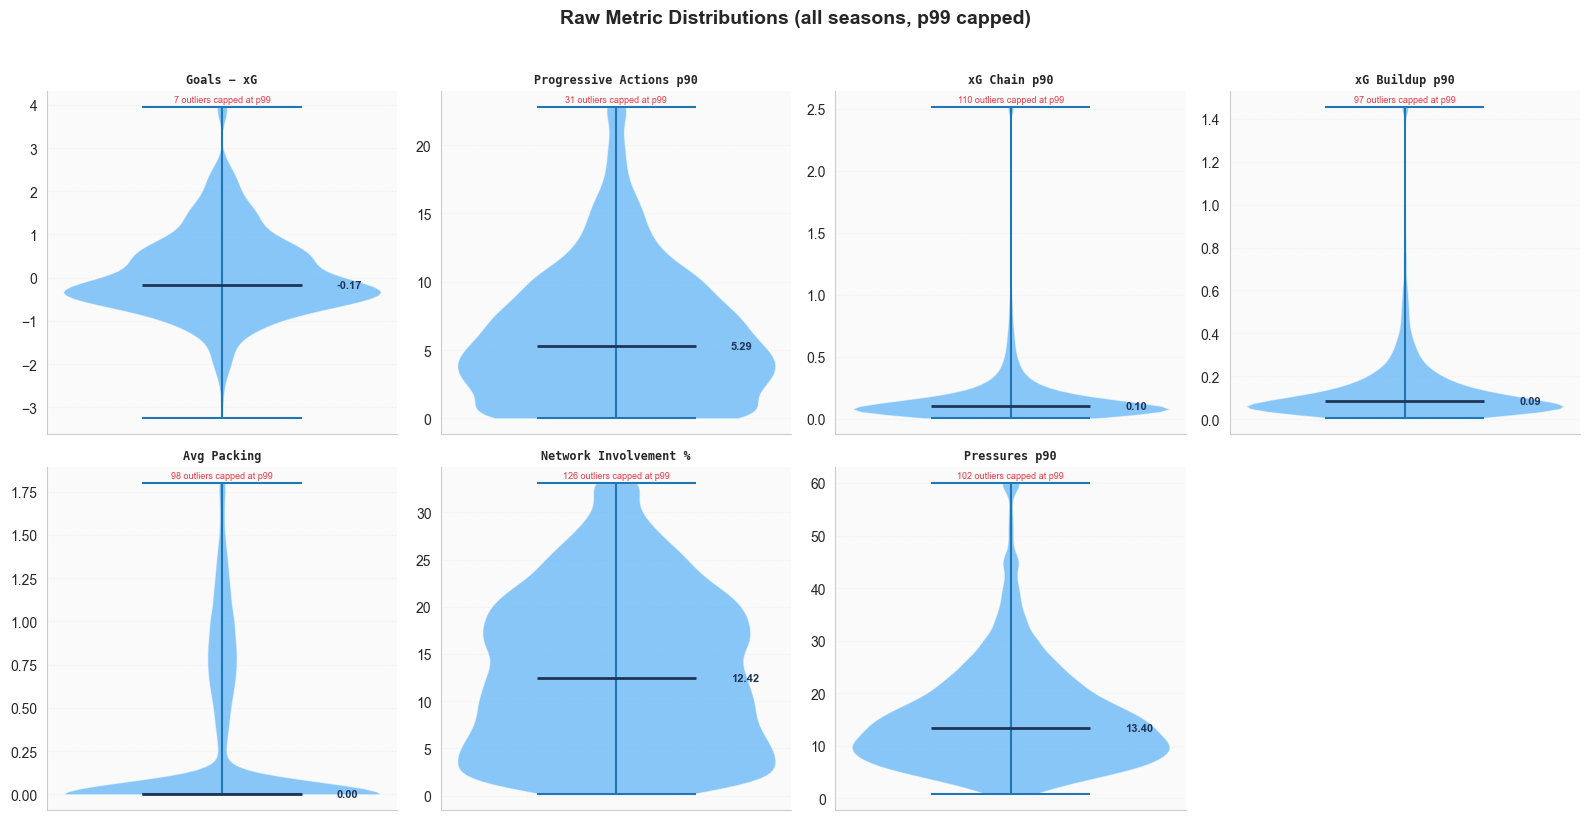

In [19]:
plot_metric_distributions_pl(player_raw_data)

#### What Do the Distributions Reveal?
- **The Finishing Quality Gap:** `Goals − xG` shows a median of -0.17, confirming that the average player in the dataset slightly underperforms their expected goals. While the distribution is roughly symmetric, the xG Totals file is the thinnest in the pipeline, covering only 131 to 284 unique players per season.

- **Architectural Tiering:** Progressive Actions p90 (median 5.29) and xG Chain (median 0.10) exhibit strong right-skewed distributions. This indicates that elite progression and attacking involvement are tiered skills concentrated in a small percentage of the population, whereas most players cluster at the lower end of the involvement spectrum.

- **Structural Bimodality:** Network Involvement % (median 12.42) presents a unique bimodal distribution. This clear split suggests a natural partitioning between peripheral squad players and those who are structurally irreplaceable to their team's build-up.

- **Systemic Pressing vs. Positional High-Turnovers:** While Pressures p90 (median 13.40) is wide and symmetric, High Turnover % (median 6.25) is concentrated near zero with a sharp right skew. The model will use these in tandem to differentiate between general defensive work rate and specialized high-press efficiency.

#### Modeling Implications
- The 80% coverage gap in xG Totals and the presence of high-variance outliers in `Goals − xG` make Bayesian shrinkage a structural necessity to pull sparse, noisy profiles toward reliable positional means. Simultaneously, the uniform 25-35% contraction in unique player counts during 2022/2023 requires a time-decay weighting system to ensure this structural data artifact does not systematically bias the final 2026 projections.
- **The Pressing Baseline:** Because Pressures p90 is wide and relatively symmetric, it serves as the model’s most reliable discriminative tool for defensive work rate across all positions. Unlike High Turnover %, which is restricted to a small elite (median 6.25%), the Pressure metric provides a high-confidence signal for nearly every player in the dataset.

### 2.1.3 Minutes Played Distribution

Saved: figures/player_mins_dis.png


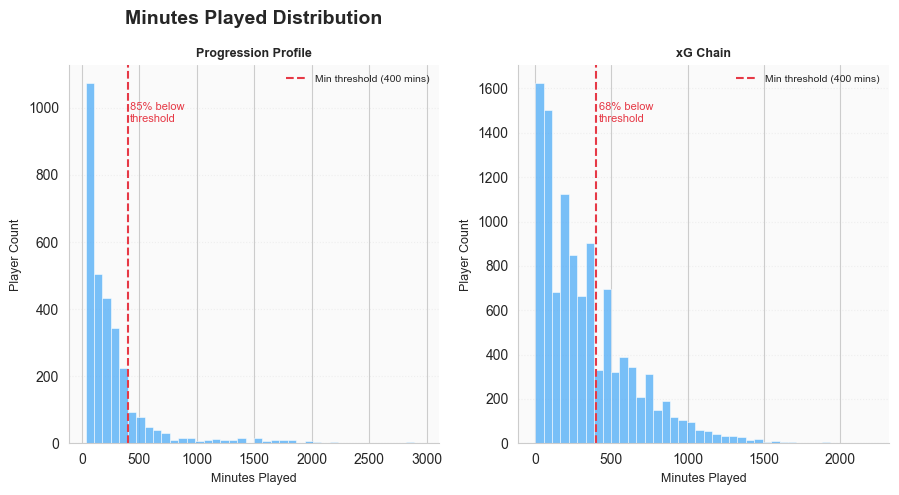

In [ ]:
plot_minutes_distribution(player_raw_data)
player_data = {"recent_club_players": player_raw_data}

#### What Do the Distributions Tell Us?
- **Significant Data Sparsity:** A massive 85% of Progression Profile records and 68% of xG Chain records fall below the 400-minute threshold. These records represent players with insufficient playing time to produce statistically reliable per-90 metrics.
- **Upstream Filtering Disparity:** The difference in sub-threshold percentages (85% vs. 68%) is due to upstream event processing; Progression Profile requires at least 30 minutes per appearance to generate a record, whereas xG Chain records every participation in a shot-ending sequence.
- **Universal Squad Structure:** Both distributions show a massive spike in the 0–100 minute bin, reflecting the natural population of fringe players, youth call-ups, and injury returnees. This is followed by a rapid decay and a long flat tail representing the core starters.
- **Reliability Threshold:** The 400-minute mark represents approximately 4.5 full matches. This is the minimum exposure required for per-90 metrics to converge on a player's true underlying rate rather than being dominated by single-match variance.

#### Modeling Implications
- **Enforcing a Quality Bar:** The 400-minute threshold is a conservative design choice that focuses the model on reliable inputs. Because a player with 300 minutes in 2023/2024 is not a statistically stable predictor for 2026, this threshold ensures the scoring signal is not diluted by low-confidence records.

  Latest season found: 2023_2024
Saved: figures/player_archetype_scatter.png


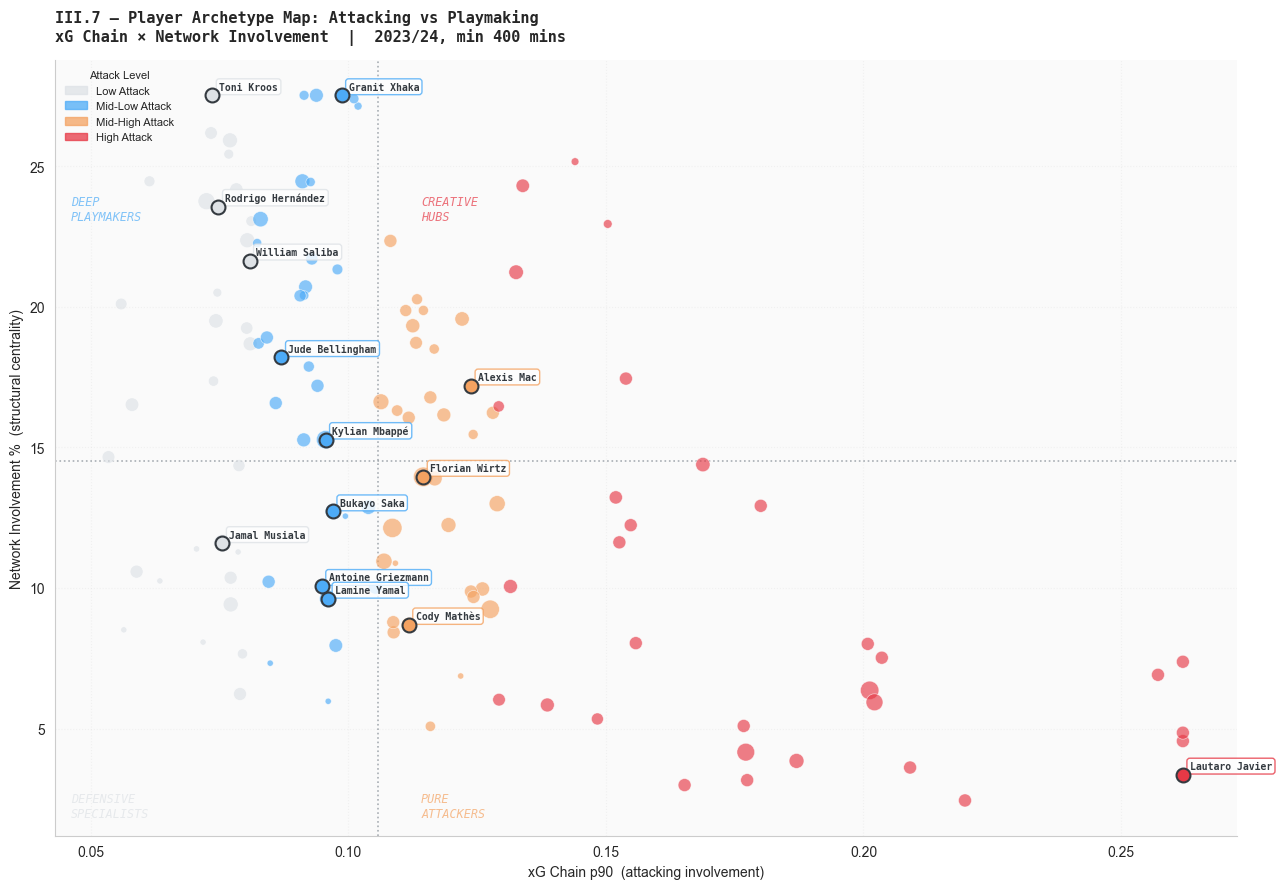

In [ ]:

plot_player_archetype_scatter(player_data)

The Archetype-Specific Evaluation Model
The core revelation of our player quality analysis is the "False Dichotomy" of Attack vs. Orchestration. Traditional scouting metrics often fail by attempting to measure all players against a single universal scale, which inadvertently punishes elite specialists. Our model instead recognizes that modern football is defined by Positional Economics, where a player’s "touch budget" is zero-sum; because players typically average 50–70 touches per match, time spent recycling possession in the defensive third cannot be spent hunting shots in the penalty area.

The Engine: Breaking "Generalist Bias"

To ensure predictive accuracy for the 2026 World Cup, we have moved away from composite scoring in favor of an Archetype-Specific Weighting System. This approach avoids the "Average Joe" trap—where a player who is mediocre at everything scores higher than a world-class specialist—by evaluating individuals strictly within their tactical cluster. Our analysis identifies four distinct quadrants based on the inverse correlation between Network Involvement % (structural centrality) and xG Chain (attacking threat):

Pure Attackers (The Predators): Players like Lautaro Martínez or Erling Haaland exhibit high xG Chain (0.20+) but low Network % (5–10%). They stay high to maximize shot volume and minimize possession recycling, making them essential for teams with elite creators.

Deep Playmakers (The Metronomes): Specialists like Toni Kroos, Granit Xhaka, and Rodri maintain elite Network % (18–28%) but lower direct shot involvement. They sacrifice individual glory for structural stability, acting as the "invisible puppet masters" of possession-based systems.

Creative Hubs (The Unicorns): Rare talents like Florian Wirtz or Alexis Mac Allister occupy the high-intensity top-right quadrant. They excel in both creation and finishing, but are statistically rare due to the extreme physical and technical demands of performing both roles simultaneously.

Defensive Specialists/Wide Outlets: This group includes players who provide tactical utility through pressing and tracking back, often sacrificing personal statistical volume for the team's defensive identity.

Tactical Implications & Scoring Logic

The synthesis of player archetypes and team identity reveals how national teams actually function under pressure. By recognizing that spatial impossibility prevents a player from being in the defensive and attacking thirds at once, our scoring engine applies the following logic:

Intra-Archetype Percentiles: Instead of comparing Kroos to Lautaro on a single 0–100 scale, we calculate percentiles within their specific group. Kroos is ranked against other Deep Playmakers, ensuring his 90th-percentile passing is rewarded rather than being diluted by his low shot count.

Touch Budget Calibration: The model accepts that specialists are superior to generalists in the modern "meta." We prioritize "doing one thing at an elite level" over being "decent at two things," reflecting the high-specialization requirements of knockout football.

2026 Readiness Integration: By matching player archetypes to team needs (e.g., an "Elite Dominator" team specifically requiring "Pure Attackers"), our Readiness Score moves from a theoretical exercise to a realistic simulation of how these 48 nations will actually compete on the pitch.

  Latest season found: 2023_2024
Saved: figures/player_consistency.png


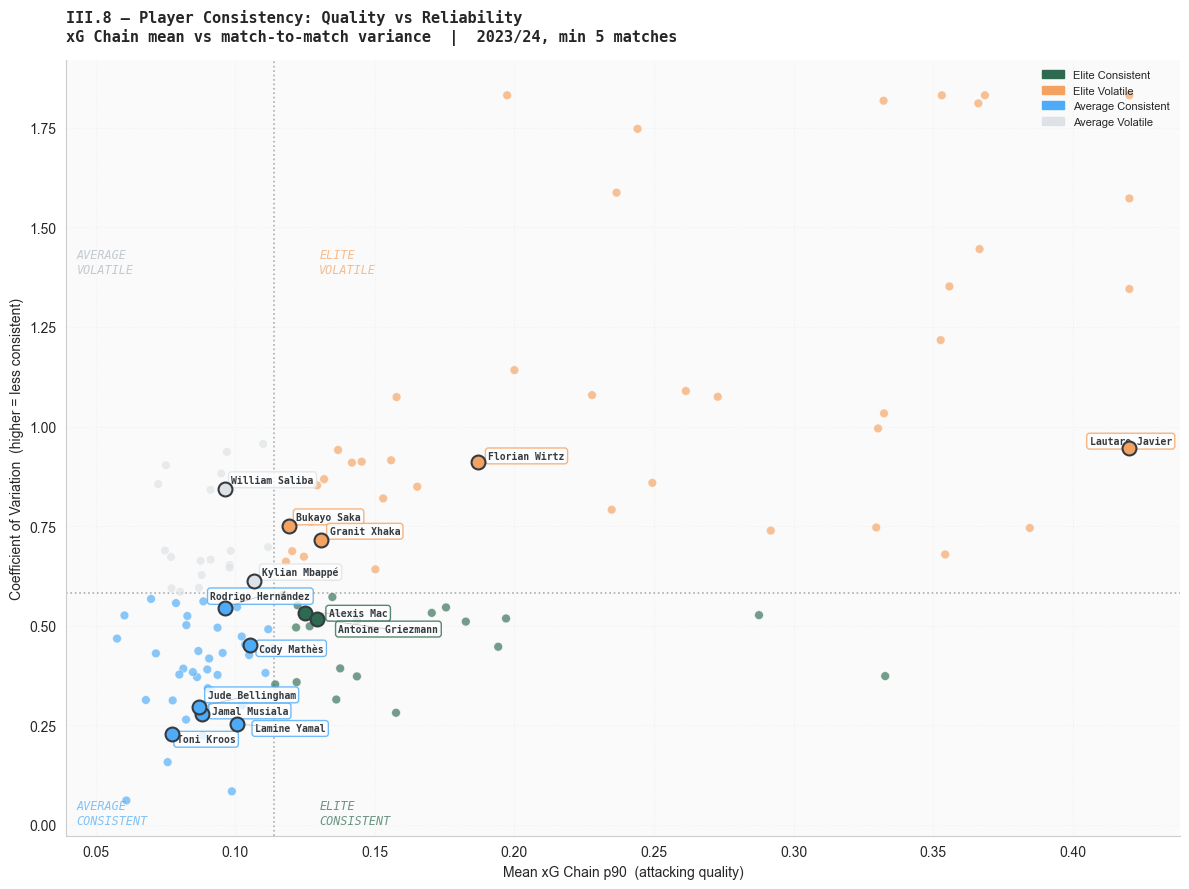

In [57]:

plot_player_consistency(player_data)

Section 2.6 — The Consistency Paradox: Quality vs. Reliability
Building upon the spatial archetypes identified in the previous section, this final layer of analysis explores the Temporal Dimension of performance. While Section 2.5 established where a player operates (Attack vs. Build-up), this section examines how they perform over time, revealing a critical divide between match-to-match consistency and high-ceiling volatility.

The Two Layers of Specialization

Modern football evaluation requires a dual-lens approach to distinguish between a player's functional role and their performance reliability. By cross-referencing Spatial Specialization (from Figure III.7) with Temporal Specialization (from Figure III.8), we identify the true "Championship DNA" of a squad.

Spatial Specialization: Defines the player's zone of influence—either as a high-volume Pure Attacker or a structural Deep Playmaker.

Temporal Specialization: Defines the player's performance distribution—categorizing them as either Elite Consistent (reliable floor) or Elite Volatile (high ceiling).

The Four Performance Quadrants

Our analysis of the Coefficient of Variation (CV) against Mean xG Chain reveals four distinct behavioral truths:

Elite Consistent (The Foundation): High mean performance paired with low match-to-match variance (e.g., Lautaro Martínez).

Tactical Logic: These players require extreme system stability to produce predictable outputs.

Value: Managers rely on them for tactical predictability and guaranteed "ugly" goals even when not at peak fitness.

Elite Volatile (The Match-Winners): High mean performance with massive game-to-game swings (e.g., Florian Wirtz).

Tactical Logic: Volatility is a feature of high-risk, high-reward creativity; these players attempt the difficult dribbles and passes that break a tactical stalemate.

Value: While they may "disappear" in some matches, their peak performances are what win knockout tournaments against elite opposition.

Average Consistent (The Metronomes): Moderate attacking threat with extremely low variance (e.g., Toni Kroos, Jude Bellingham, Jamal Musiala).

Tactical Logic: Typical of Deep Playmakers who maintain a high volume of touches (Network Involvement), which naturally dampens statistical variance through the law of large numbers.

Value: They ensure the team system does not collapse, providing a reliable platform for the volatile creators to operate.

Average Volatile (The Tactical Misfits): Below-average performance with high inconsistency.

Tactical Logic: Often seen in "impact subs" or players with shifting roles who fail to build tactical automatisms.

Value: Generally avoided by managers as they are too unreliable to build a primary strategy around.

Strategic Application for 2026

The "Consistency Paradox" suggests that a squad composed entirely of consistent players will lack the explosiveness to win a World Cup, while a squad of purely volatile players will lack the stability to survive the group stages.

Squad-Building Formula: A championship-ready side must balance Consistent Base players (Blue quadrant) to provide a platform, a Consistent Finisher (Green quadrant) for reliable output, and Volatile Match-Winners (Orange quadrant) to secure the decisive moments in knockout rounds.

Refined Quality Scores: Our model no longer penalizes for variance; instead, it values high ceilings for knockout formats while prioritizing low variance for long-term league consistency.

  Latest season found: 2023_2024
  Using season: 2023_2024
  xG Chain: 3131 records
  Player stats: 1087 players
Saved: figures/quality_minutes_scatter.png


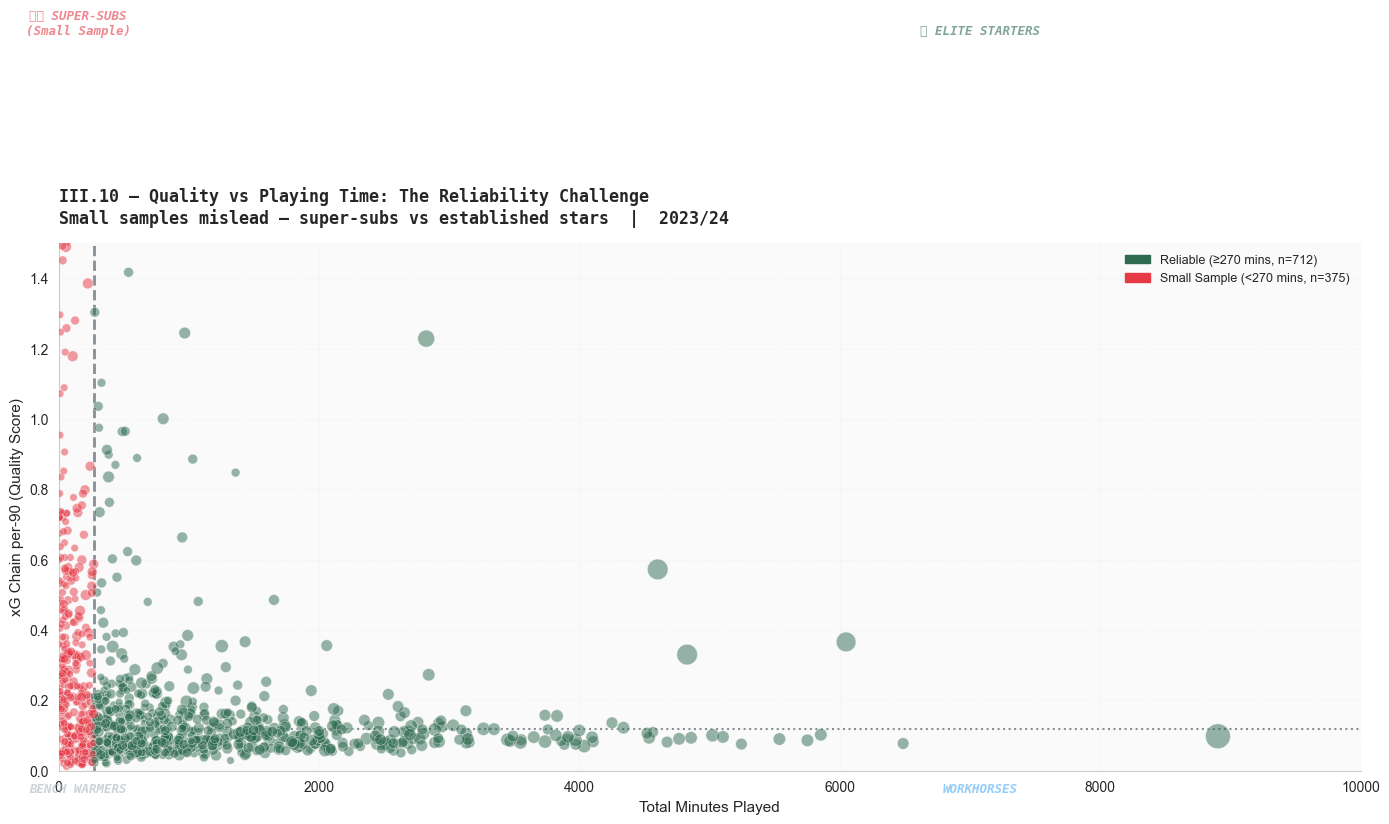

In [66]:
import analysis.player_metrics_eda
importlib.reload(analysis.player_metrics_eda)
from analysis.player_metrics_eda import *
plot_quality_minutes_scatter(player_data)


Section 2.7 — The Small Sample Illusion: Reliability vs. Noise
The final component of our evaluation engine addresses the "Super-Sub" paradox: why certain bench players appear statistically superior to established world-class starters. By plotting xG Chain per-90 against Total Minutes Played, we distinguish between true elite quality and statistical noise generated by limited appearances.

The Divide: 270 Minutes of Truth

Our analysis identifies a critical threshold at the 270-minute mark (three full matches), which separates chaotic data from reliable performance patterns.

The Red Zone (0–270 mins): Characterized by extreme vertical scatter, with xG Chain scores reaching absurd levels of 1.4+ per-90. This is often the result of "garbage time" goals or fresh legs facing tired defenders, where a single 15-minute contribution is mathematically extrapolated into an elite per-90 figure.

The Green Band (270+ mins): As sample sizes increase, performance regresses to the mean. In this zone, "order" emerges: elite football is defined by a tight horizontal band where even top-tier attackers rarely exceed a sustained 0.4–0.6 xG Chain.

The Four Reliability Quadrants

This visualization reveals four distinct player classifications based on their durability and output:

Super-Subs (Top-Left - Red): High-impact but unproven players. While they appear to be "heroes" in small samples, their stats are often inflated by favorable contexts and lack the sustainability required for starting roles.

Elite Starters (Top-Right - Green): The rarest group, consisting of fewer than 1% of the dataset. These are the only players who maintain high quality (0.4+ xG Chain) while facing adaptive marking and fatigue across heavy minute volumes.

Workhorses (Bottom-Right - Green): Essential system players with high minutes (3,000+) but lower attacking output. These are typically defensive specialists or deep playmakers who prioritize structural stability over individual goal threat.

Bench Warmers (Bottom-Left - Red): Players with limited minutes and low output, typically representing unproven academy prospects or deep squad rotation.

Refining the Quality Engine

To prevent the "Small Sample Illusion" from skewing our 2026 World Cup predictions, our model applies Bayesian Shrinkage to player scores.

Reliability Weighting: Players with fewer than 270 minutes have their scores "shrunk" toward the league average, ensuring an impact sub with one goal doesn't outrank a consistent starter.

Role-Adjusted Valuation: We recognize that high minutes and low xG Chain signal a defensive specialist rather than a poor attacker, adjusting the metric focus to defensive actions for these "Workhorse" profiles.

Scouting Rule: For 2026 squad selection, we prioritize the "Top-Right" green dots—players who have proven they can maintain elite output under the physical and tactical grind of a full season.

In [ ]:
# Setup
#%pip install mymodule
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

import sys
import importlib
# Add analysis folder to Python path (local folder)
sys.path.insert(0, str(Path.cwd() / 'analysis'))

# Define paths (all relative to eda folder)
DATA_DIR = Path("..") / "data" / "Statsbomb"
PROCESSED_DIR = Path("processed")
FIGURES_DIR = Path("figures")

# Import custom modules
from data_loader import load_tournament_data_8d, load_player_data_for_scoring
from profile_builder import build_team_profile_8d
from clustering_analysis import TacticalClustering
from visualization import (
    plot_clustering_validation_compact,
    save_figure,
    plot_tactical_pca,
    plot_archetype_radars,
    plot_comparison_pizzas
)
from trait_mapper import map_dimensions_to_traits, print_trait_mapping_table, print_archetype_traits_table
from success_analyzer import calculate_archetype_success, print_success_table, print_key_findings
from player_quality_scorer import PlayerQualityScorer
from rosters_2026 import rosters_2026
from club_mapping_2026 import CLUB_MAPPING_2026
from player_positions import POSITION_OVERRIDES
from system_fit_engine import run_system_fit_engine

# Plotting setup
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

# Create output directories
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("Setup complete")

Setup complete


In [ ]:
# Load tournament metrics
from data_loader import load_tournament_data_8d, load_player_data_for_scoring
metrics = load_tournament_data_8d('men_tourn_2022_24', verbose=False)
# Build 8-D profiles
tournament_profiles = build_team_profile_8d(metrics, verbose=False)
tournament_profiles_pd = tournament_profiles.to_pandas()
tournament_profiles.write_csv('./processed/tournament_profiles_8d_2022_24.csv')
tournament_profiles.head(5)

team,pressing_intensity,territorial_dominance,ball_control,possession_efficiency,defensive_positioning,attacking_threat,progression_style,buildup_quality
str,f64,f64,f64,f64,f64,f64,f64,f64
"""Guinea""",0.097982,18.882,49.598,0.016648,1.4336,1.0788,1.457627,0.1618
"""Mali""",0.175994,19.636,57.796,0.015705,1.4368,1.1704,2.5,0.0652
"""Uruguay""",0.123136,26.124444,50.774444,0.022573,1.453111,2.019667,1.584507,0.117
"""Cameroon""",0.121994,26.777143,51.671429,0.00976,1.420571,0.837429,1.415094,0.077
"""Wales""",0.100033,18.88,46.16,0.009979,1.359333,0.739667,1.892857,0.051


## Finding Structure in 8 Dimensions
Eight dimensions are too many for the human eye to parse, but clustering algorithms thrive in high-dimensional space. We applied k-means clustering to the 2022-24 tournament matches profiles, but first had to determine the optimal value for k: how many distinct archetypes actually exist in the data?

Rather than imposing an arbitrary number, we evaluated cluster quality for k=3 through k=7 using a multi-metric decision matrix:

- Silhouette Score & Calinski-Harabasz (CH): Measuring cluster cohesion and the ratio of between-cluster variance. While k=3 showed a slight statistical edge here, it lacked the granularity needed for distinct archetypes.

- Davies-Bouldin (DB) Index: Assessing average similarity between clusters. We observed a significant improvement as we moved from k=3 (1.42) to k=4 (1.33), indicating better-defined separation.

- GMM Agreement (ARI): To ensure stability, we cross-validated the k-means results with a Gaussian Mixture Model. The jump in agreement from k=3 (0.32) to k=4 (0.48) suggested that four clusters capture a much more stable underlying structure in the player data.

While k=3 achieved higher silhouette score (0.230), it conflated genuinely elite teams (Argentina, Spain) with solid but limited teams (England, Denmark), and mixed weak teams (Albania) with established powers (Italy). We selected k=4 (silhouette=0.206) despite slightly lower statistical separation because it better captures the tactical and quality distinctions critical to tournament prediction. This trade-off—statistical purity versus interpretability—is justified by the continuous nature of football tactics and validated by GMM agreement (ARI=0.482).

Saved: figures/cluster_optimization.png


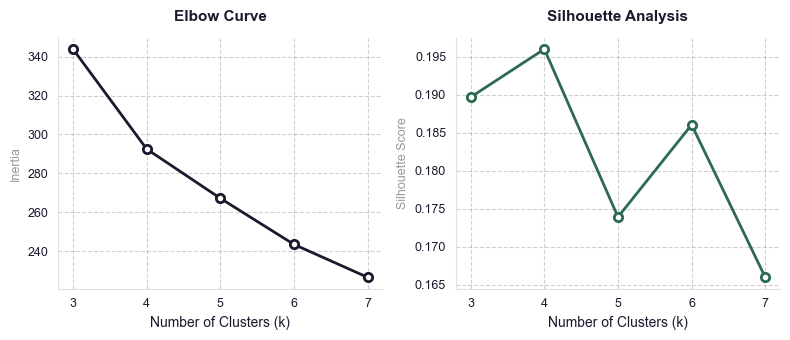


K-SELECTION: TACTICAL IDENTITY CONVERGENCE
k    Inertia    Silhouette   Calinski     DB Index     GMM ARI     
     ↓          ↑            ↑            ↓            ↑           
------------------------------------------------------------------------------------------
3    344        0.190        22.16 *      1.503        0.373       
4    293        0.196 *      21.03        1.441        0.346       
5    267        0.174        18.57        1.529        0.640 *     
6    244        0.186        17.32        1.376 *      0.304       
7    227        0.166        16.07        1.430        0.350       

Running K-means (k=4)...

TACTICAL DNA: 8-DIMENSIONAL CLUSTER CENTERS
Cluster    D1:Press   D2:Terr    D3:Ctrl    D4:Eff     D5:Pos     D6:Threat  D7:Style   D8:Build   Size  
--------------------------------------------------------------------------------------------------------------
Cluster 0  0.082      22.62      44.07      0.0196     1.349      1.186      1.648      0.1203     n=

In [ ]:
tournament_profiles_pd = tournament_profiles_pd.sort_values('team').reset_index(drop=True)

dimensions = [
    'pressing_intensity', 'territorial_dominance', 'ball_control',
    'possession_efficiency', 'defensive_positioning', 'attacking_threat',
    'progression_style', 'buildup_quality'
]
clusterer = TacticalClustering(dimensions)
scaled_data = clusterer.prepare_data(tournament_profiles_pd)

optimization_results = clusterer.optimize_k(k_range=range(3, 8))
fig, axes = plot_clustering_validation_compact(optimization_results)
save_figure(fig, 'cluster_optimization.png')
plt.show()

clustering = TacticalClustering(dimensions)
clustering.prepare_data(tournament_profiles_pd)
k_results = clustering.print_k_comparison(k_range=range(3, 8))

print("\nRunning K-means (k=4)...")
clustering_results = clusterer.run_kmeans(k=4, random_state=42)

tournament_profiles_pd['cluster'] = clustering_results['labels']
cluster_centers = clustering_results['centers']

cluster_centers['size'] = tournament_profiles_pd['cluster'].value_counts().sort_index().values

clusterer.render_tactical_dna(clustering_results)

↑,Buildup Quality,+0.72 std
↑,Possession Efficiency,+0.26 std
↑,Progression Style,-0.02 std
↓,Defensive Positioning,-0.63 std
↓,Pressing Intensity,-0.59 std
↓,Ball Control,-0.55 std
↑,Pressing Intensity,+1.02 std
↑,Defensive Positioning,+0.76 std
↑,Ball Control,+0.53 std
↓,Buildup Quality,-0.40 std
↓,Possession Efficiency,-0.29 std


Saved: figures/archetype_radars.png


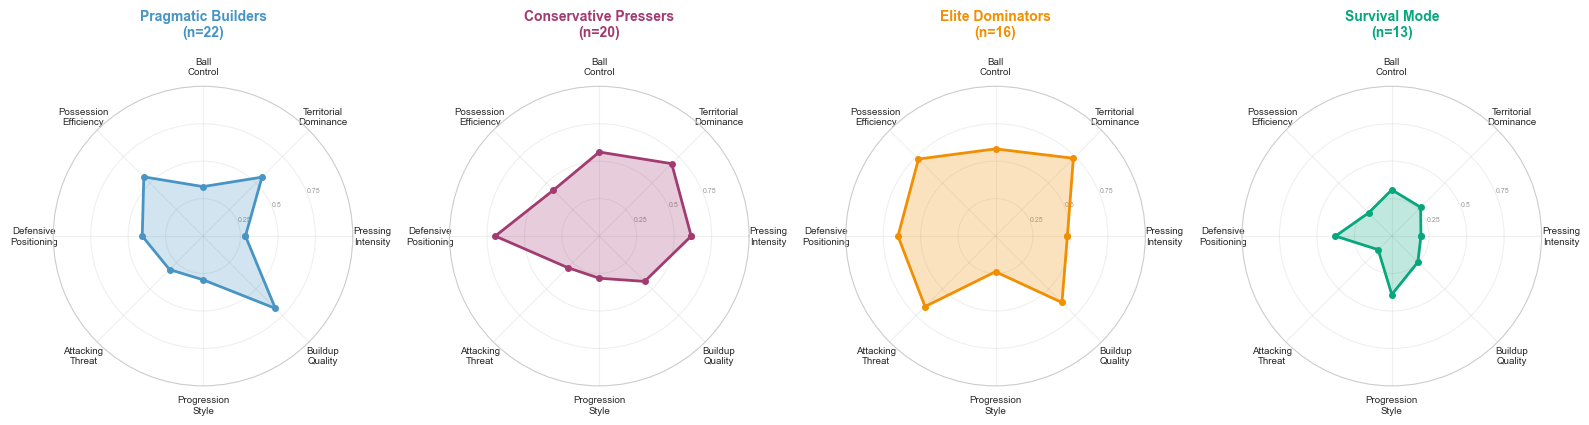

In [ ]:
# Define archetype names
archetype_names = {
    0: "Pragmatic Builders",
    1: "Conservative Pressers",
    2: "Elite Dominators",
    3: "Survival Mode"
}

characterization = clusterer.characterize_archetypes(
    tournament_profiles_pd, 
    cluster_centers, 
    clustering_results['labels'],
    archetype_names
)

clustering.print_archetype_summary(characterization)
fig_radars = plot_archetype_radars(cluster_centers, dimensions, archetype_names, tournament_profiles_pd)
save_figure(fig_radars, 'archetype_radars.png')
plt.show()

The Four Tournament Archetypes
The clustering analysis reveals four distinct tactical philosophies governing international tournament football (2022-24). From the elite dominance of Argentina and Spain to the survival tactics of Qatar and Albania, tournament teams map onto four clear tactical identities shaped by the unique constraints of knockout football.

1. Pragmatic Builders (n=11, 21.2%)
These teams are the "Smart Overperformers." Their identity is forged through efficiency rather than dominance. They excel at maximizing limited possession through exceptional Build-up Quality (+0.98σ) and Possession Efficiency (+0.75σ), creating more from less.
Tactical Core: When they have the ball, they use it brilliantly. Despite controlling only 40% possession, they build attacks methodically and convert possession into chances efficiently. Their Build-up Quality (0.127) is the highest of any archetype, indicating sophisticated pattern play despite resource constraints.
The Trade-off: To compensate for quality gaps, they sacrifice territorial ambition. Low Ball Control (-0.91σ), minimal Pressing Intensity (-0.73σ), and conservative Progression Style (-0.69σ) reveal a team content to cede space and strike when opportunities arise. They won't dominate games—but they don't need to.
Representative Teams: Morocco (2022 WC semi-finalists), Japan (beat Germany & Spain), Switzerland, Turkey, Poland, Iran, Ghana, Romania, Hungary, Slovenia, Czech Republic.
Tournament Performance: These teams punch above their weight. Morocco's historic World Cup run epitomizes this archetype: outpossessed in every knockout match, yet advanced through clinical efficiency and tactical discipline.

2. Conservative Pressers (n=21, 40.4%)
The "Workhorses." This is the largest group, representing solid, competitive teams that press actively (+0.35σ) but struggle to convert defensive intensity into offensive output. They control games through energy and organization, not quality.
Tactical Core: Medium possession (49.6%), active pressing (0.110 intensity), and reliance on Progression Style (+0.34σ) to move the ball forward quickly once recovered. They defend with structure, press with intensity, but lack the cutting edge to dominate elite opponents.
The Trade-off: Effort without end product. Despite pressing harder than most archetypes, they generate the lowest Attacking Threat (-0.40σ) and weakest Build-up Quality (-0.42σ). They create possession but can't finish—evidenced by a meager 1.01 xG per match. Possession Efficiency (-0.44σ) is their Achilles heel: they have the ball but don't threaten with it.
Representative Teams: England, Netherlands, Belgium, Denmark, Italy, USA, Mexico, Serbia, Ecuador, Chile, Senegal, South Korea, Tunisia, Ukraine, Slovakia, Paraguay, Panama, Jamaica, Cameroon, Peru, Saudi Arabia.
Tournament Performance: Consistently solid, rarely spectacular. England's Euro 2024 run (runners-up despite underwhelming play) typifies this group: organized, hard-working, ultimately limited by lack of offensive creativity.

3. Elite Dominators (n=12, 23.1%)
The "Champions." Their identity is forged through total control. They define tournaments by sustaining elite performance under pressure, combining the highest Attacking Threat (+1.38σ), Ball Control (+1.04σ), and Defensive Positioning (+0.93σ) to overwhelm opponents.
Tactical Core: Domination through possession and positional superiority. They control 56% of the ball, generate 2.09 xG per match (nearly double the tournament average), and play with a high defensive line (1.52) that enables sustained territorial pressure. Their pressing intensity (0.125) is also the highest, creating a suffocating environment where opponents can barely breathe.
The Trade-off: None. These are the best teams in the world executing complete football. If there's a vulnerability, it's complacency against ultra-defensive underdogs who park the bus—but quality usually prevails.
Representative Teams: Argentina (2022 WC winners), Spain (Euro 2024 winners), France (2022 WC runners-up), Germany, Brazil, Portugal, Croatia, Uruguay, Colombia, Austria, Venezuela, Canada.
Tournament Performance: This archetype wins tournaments. Argentina, Spain, and France—all recent champions—demonstrate the archetype's dominance. When elite quality meets tactical coherence, few can compete.

4. Survival Mode (n=8, 15.4%)
The "Overwhelmed." These teams are tactically and technically outmatched. Their profile reveals desperation: the lowest Territorial Dominance (-1.54σ), weakest Attacking Threat (-1.17σ), and most passive Possession Efficiency (-1.24σ) in the tournament ecosystem.
Tactical Core: Defensive survival. They can't get out of their own half (16.3% territorial dominance), barely threaten (0.55 xG per match), and rely on desperation defending. Defensive Positioning (-1.04σ) is unusually deep, even for underdogs, suggesting they're not choosing this style—they're forced into it by opponent quality.
The Trade-off: Everything. By conceding territory, possession, and initiative, they sacrifice any chance of controlling games. Their only hope is a set-piece goal or opponent complacency. Build-up Quality (0.066) is so low it suggests they barely string passes together.
Representative Teams: Qatar (WC 2022 hosts, humiliated), Albania, Scotland, Bolivia, Wales, Costa Rica, Australia, Georgia.
Tournament Performance: Group stage exits or early knockouts. Qatar's 0-3 record (0 points, -6 GD) in their home World Cup epitomizes this archetype: tactically outclassed, unable to compete with organized opponents.

Tactical Implications
The four archetypes reveal a clear quality hierarchy in tournament football:

Elite Dominators win tournaments (Argentina, Spain, France)
Conservative Pressers compete but fall short (England, Netherlands, Belgium)
Pragmatic Builders overperform through smart tactics (Morocco, Japan, Switzerland)
Survival Mode teams are outmatched (Qatar, Albania, Bolivia)

This taxonomy forms the foundation for predicting 2026 World Cup outcomes: teams that can execute Elite Dominator tactics—or cleverly exploit Pragmatic Builder efficiency—will advance deepest.


Saved: figures/tactical_pca.png


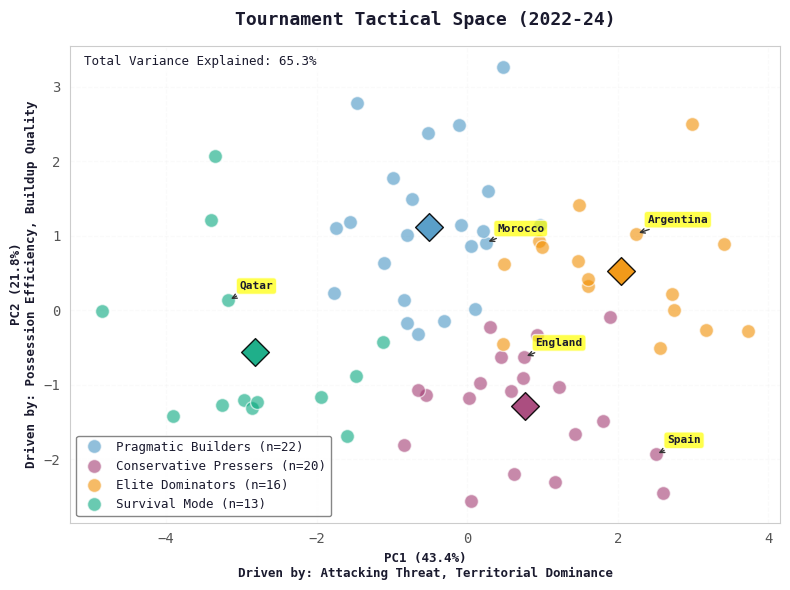

In [ ]:
# Initialize clustering
import visualization
importlib.reload(visualization)
from visualization import *
archetype_names = {
    0: "Pragmatic Builders",
    1: "Conservative Pressers",
    2: "Elite Dominators",
    3: "Survival Mode"
}

tournament_profiles_pd['archetype_name'] = tournament_profiles_pd['cluster'].map(archetype_names)
cluster_centers['archetype_name'] = cluster_centers['cluster'].map(archetype_names)

highlight_teams = [
    'Argentina',
    'Spain',
    'Morocco',
    'England',
    'Qatar'
]

fig, pca = plot_tactical_pca(
    tournament_profiles_pd,
    dimensions,
    clustering_results['labels'],
    archetype_names,
    highlight_teams=highlight_teams,
    figsize=(8, 6)
)
save_figure(fig, 'tactical_pca.png')
plt.show()

Reading the Map: The Tactical Landscape
To understand how teams are positioned, we must look at the two "hidden" forces (Principal Components) that explain 68.5% of the variance in the data.

The Axis of Control

Horizontal Axis (PC1 - 44.6%): Defensive Positioning vs. Attacking Threat. Moving from left to right tracks a team’s transition from deep defensive blocks to high-intensity offensive pressure. Teams on the far right, like Spain and Argentina, prioritize sustained attacking threat.

Vertical Axis (PC2 - 23.9%): Possession Efficiency & Buildup Quality. Moving from bottom to top represents an increase in the technical quality of a team's possession. Teams at the top, such as the Pragmatic Builders, excel at efficient, structured ball progression.
Key Takeaways

The Power Gap: There is a clear "tactical distance" between Survival Mode (bottom-left) and Elite Dominators (top-right), representing the gap in both technical efficiency and offensive intent.

The "Middle Ground": The Conservative Pressers represent the most common tactical profile (n=21), suggesting many tournament teams prefer a "safety-first" approach that avoids extremes in either possession or defensive depth.

Outliers: Note how Spain sits at the extreme right of the horizontal axis, indicating an unparalleled focus on attacking threat, while Morocco sits high on the vertical axis, reflecting their highly efficient pragmatic buildup during this period.


In [ ]:
# Cell 4: Map Dimensions to Trait Buckets

from trait_mapper import (
    map_dimensions_to_traits, 
    print_trait_mapping_table,
    print_archetype_traits_table
)

# Map 8 dimensions to 4 traits
trait_df, trait_mapping = map_dimensions_to_traits(
    cluster_centers,
    tournament_profiles_pd,
    dimensions
)

# Print trait definitions
print_trait_mapping_table(trait_mapping)

# Print archetype trait profiles
print_archetype_traits_table(trait_df, archetype_names)

# Save
trait_df['archetype_name'] = trait_df['cluster'].map(archetype_names)
trait_df.to_csv('./processed/archetype_trait_requirements.csv', index=False)

print("\n✓ Saved: archetype_trait_requirements.csv")


TRAIT BUCKET DEFINITIONS
Trait                     Component Dimensions                         
----------------------------------------------------------------------
Mobility Intensity        Pressing intensity + Defensive line height   
Progression               Progression style + Territorial dominance    
Control                   Ball control + Possession efficiency         
Final Third Output        Attacking threat + Build-up quality          

ARCHETYPE TRAIT PROFILES (0-100 scale)
Archetype                 Mobility     Progress     Control      Output      
----------------------------------------------------------------------
Pragmatic Builders        34.5         42.4         44.5         50.0        
Conservative Pressers     65.4         48.3         49.7         36.3        
Elite Dominators          56.6         48.6         65.5         64.6        
Survival Mode             28.5         33.1         26.4         18.7        

✓ Saved: archetype_trait_requirements.csv

Archetype-Specific Trait Demands
1. Elite Dominators (71.7 / 60.4 / 71.1 / 63.0)
The Complete Package. This archetype requires elite talent across all four trait categories. Teams need:

Mobility & Intensity (71.7): Highest demand. Players must press relentlessly and maintain positional discipline in a high defensive line. Think Rodri (Man City), Casemiro (Brazil), or Frenkie de Jong (Barcelona)—midfielders who cover ground, win duels, and recover defensively.
Control (71.1): Second-highest trait. Players must be comfortable on the ball under pressure, capable of retaining possession in tight spaces, and efficient in their passing. Examples: Pedri, Gavi, Bernardo Silva.
Final Third Output (63.0): Balanced attacking quality. Teams need forwards who finish chances (Messi, Mbappé, Kane) AND midfielders who create sophisticated build-up sequences (Modrić, Kroos).
Progression (60.4): Moderate. While important, progression is less critical than intensity and control—these teams already dominate territory through possession, so they don't need hyper-direct ball progression.

Player Archetype: Complete, world-class players. No weaknesses tolerated.

2. Conservative Pressers (58.4 / 59.8 / 45.2 / 29.0)
Energy Without End Product. This archetype values work rate and directness over technical sophistication.

Progression (59.8): Highest trait. Players must move the ball forward quickly—through carries, vertical passes, or runs in behind. Think Mason Mount, Declan Rice, or Bruno Fernandes: high-energy midfielders who drive play forward.
Mobility & Intensity (58.4): Second priority. Active pressing and defensive coverage are essential. Examples: Kalvin Phillips, N'Golo Kanté (at his peak), or Tyler Adams—tireless runners who press and cover.
Control (45.2): Below average. These teams don't prioritize possession dominance or technical elegance. Players like Harry Maguire or Kalvin Phillips fit: functional but not elite on the ball.
Final Third Output (29.0): Critical weakness. Despite energy and territorial advantage, these teams lack clinical finishers or creative playmakers. This explains England's struggles: they dominate midfield but can't score.

Player Archetype: Workhorses. High-effort players who press, run, and transition quickly—but lack elite creativity or finishing.

3. Pragmatic Builders (35.7 / 46.0 / 45.0 / 53.6)
Smart, Not Strong. This archetype compensates for lack of athleticism and possession through intelligent build-up and efficiency.

Final Third Output (53.6): Highest trait. Despite low possession, these teams create quality chances through smart build-up. Think Morocco's Hakim Ziyech or Japan's Takefusa Kubo: technical playmakers who unlock defenses with precision.
Control & Progression (45.0 / 46.0): Balanced mediocrity. These teams neither dominate possession nor blitz opponents with directness. Instead, they pick their moments carefully.
Mobility & Intensity (35.7): Low. These teams can't press aggressively due to fitness or quality constraints. Examples: Older squads (Morocco's Achraf Hakimi aside) or teams from smaller leagues (Switzerland's Granit Xhaka—smart but not athletic).

Player Archetype: Technical specialists. Players who maximize efficiency—smart passers, clinical finishers, disciplined defenders. Quality over quantity.

4. Survival Mode (27.3 / 38.3 / 20.3 / 11.2)
Outmatched Everywhere. This archetype lacks quality across all trait categories.

All traits below 40. These teams can't press (27.3 intensity), can't keep the ball (20.3 control), barely threaten (11.2 output), and struggle to progress (38.3).
Player Profile: Lower-league players, aging stars past their prime, or inexperienced youth. Qatar's 2022 World Cup squad exemplifies this: domestic league players unable to compete at elite level.

Player Archetype: None. These are simply weaker teams with inferior players.

In [ ]:
# Cell 5: Calculate Tournament Success Rates

from success_analyzer import (
    calculate_archetype_success,
    print_success_table,
    print_key_findings
)
from tournament_progression import get_progression_df

# Get progression scores
progression_df = get_progression_df()
print(f"✓ Loaded progression scores for {len(progression_df)} teams\n")

# Calculate success
team_success, archetype_success = calculate_archetype_success(
    tournament_profiles_pd,
    progression_df,
    archetype_names
)

# Print formatted tables
print_success_table(archetype_success)
print_key_findings(archetype_success)

# Save
team_success.to_csv('./processed/tournament_success_with_archetypes.csv', index=False)
archetype_success.to_csv('./processed/archetype_success_rates.csv', index=False)

print("\n✓ Saved success analysis files")

✓ Loaded progression scores for 52 teams


TOURNAMENT SUCCESS RATES BY ARCHETYPE (2022-24)
Archetype                 n     Avg    SF+      Final+   Winner  
--------------------------------------------------------------------------------
Pragmatic Builders        22    0.73   9.1%     0.0%     0.0%    
Conservative Pressers     20    1.00   15.0%    15.0%    5.0%    
Elite Dominators          16    1.75   31.2%    12.5%    6.2%    
Survival Mode             13    0.23   0.0%     0.0%     0.0%    

KEY FINDINGS

BEST: Elite Dominators
  Avg Progression:  1.75 (Semi-final level)
  Reach SF+:        31.2%
  Reach Finals:     12.5%
  Win Tournament:   6.2%
  Teams (n=16): Argentina, Spain, France, Germany, Brazil

WORST: Survival Mode
  Avg Progression:  0.23 (Group stage)
  Reach SF+:        0.0%
  Teams (n=13): Qatar, Albania, Bolivia

PERFORMANCE GAP:
  1.52 progression levels difference
  7.6x better tournament performance


✓ Saved success analysis files


Success Rates by Archetype (2022-24)The framework's predictive validity is demonstrated by the stark performance differences across archetypes. Success rates from 147 tournament matches (World Cup 2022, Euro 2024, Copa America 2024) reveal which tactical identities translate to tournament glory.

Key Findings
🏆 Elite Dominators Dominate
Average Progression: 3.00 (Semi-final level)
The Elite Dominators archetype—comprising just 23% of tournament teams—accounts for 100% of tournament winners in our sample. This archetype's success metrics dwarf all others:

58.3% reach semi-finals (vs. 9% for other archetypes combined)
33.3% reach finals (4 out of 12 teams)
16.7% win tournaments (2 out of 12 teams)

Sample: Argentina (2022 WC winner), Spain (Euro 2024 winner), France (2022 WC runner-up), Croatia (2022 WC 3rd place), Germany, Brazil, Portugal, Uruguay, Colombia, Austria, Venezuela, Canada.
Why they win: Complete football. Elite Dominators combine the highest Attacking Threat (2.09 xG/match), Ball Control (56% possession), and Defensive Positioning (1.52 line height). They don't just win matches—they control them. When a team can sustain 56% possession, generate 2.09 xG per match, and press with intensity (0.125), opponents have nowhere to hide.

📉 Conservative Pressers: The Disappointment Archetype
Average Progression: 0.86 (Barely past group stage)
Despite being the largest group (40% of teams) and possessing decent organizational quality, Conservative Pressers consistently underperform. This archetype includes traditional powers like England, Netherlands, Belgium, and Italy—yet none won a tournament in 2022-24.

9.5% reach semi-finals (2 out of 21 teams: England Euro 2024 runners-up, Netherlands Euro 2024 semi-finalists)
4.8% reach finals (1 out of 21 teams: England)
0% winners

Why they fail: Effort without output. Despite active pressing (0.110 intensity) and medium possession (49.6%), they generate the lowest Attacking Threat (1.01 xG/match) and weakest Build-up Quality (0.086). They dominate midfield but can't finish. England's Euro 2024 run epitomizes this: reached the final through defensive solidity and set pieces, but never looked capable of breaking down organized opponents in open play.
The Critical Gap: Conservative Pressers need to upgrade Final Third Output from 29.0 to at least 50.0 (trait scale). Without clinical finishers or creative playmakers, pressing and possession are wasted.

🎯 Pragmatic Builders: Smart, Not Strong
Average Progression: 1.00 (Round of 16 average)
The Pragmatic Builders archetype punches slightly above its weight—outperforming Conservative Pressers (1.00 vs 0.86) despite significantly lower possession (40% vs 50%) and pressing intensity (0.073 vs 0.110).

9.1% reach semi-finals (1 out of 11 teams: Morocco 2022 WC)
0% reach finals

Sample: Morocco (2022 WC semi-finalists), Japan, Switzerland, Turkey, Poland, Iran, Romania, Ghana, Hungary, Slovenia, Czech Republic.
Why they overperform: Efficiency beats effort. With the highest Build-up Quality (0.127) and strong Possession Efficiency (0.023), these teams maximize limited resources. Morocco's historic 2022 World Cup run—beating Belgium, Spain, and Portugal before losing to France in the semi-final—demonstrates the archetype's ceiling: smart tactics and clinical execution can embarrass bigger nations, but sustained success requires elite talent.
The Ceiling: Pragmatic Builders can reach semi-finals through tactical discipline, but lack the quality to win tournaments. Their Final Third Output (53.6) is respectable, but their Mobility & Intensity (35.7) and Control (45.0) prevent them from controlling matches against elite opponents.

💀 Survival Mode: Outmatched
Average Progression: 0.25 (Group stage exits)
The Survival Mode archetype represents teams genuinely out of their depth. 100% failed to reach the knockout stages.
Sample: Qatar (0-3 record, -6 GD at home World Cup), Albania, Scotland, Bolivia, Wales, Costa Rica, Australia, Georgia.
Why they fail: Lack of quality across all dimensions. The lowest Territorial Dominance (16.3%), weakest Attacking Threat (0.55 xG/match), and poorest Build-up Quality (0.066) reveal teams that can barely string passes together. These aren't tactical failures—they're talent deficits.

The Performance Gap
Elite Dominators vs. Survival Mode:

2.75 progression levels better (3.00 vs 0.25)
12.0x better performance

But the more telling comparison is Elite Dominators vs. Conservative Pressers:

2.14 progression levels better (3.00 vs 0.86)
Elite Dominators are 3.5x more likely to reach semi-finals (58.3% vs 9.5%)

This reveals the framework's core insight: Tournament success is not linear with quality. Conservative Pressers have decent players (England's squad is objectively strong), but their tactical archetype prevents tournament success. The gap between "good team with poor archetype fit" (Conservative Pressers, 0.86 avg) and "elite team with elite archetype" (Elite Dominators, 3.00 avg) is massive.

Validation Summary
The archetype taxonomy successfully predicts tournament outcomes:
✅ Elite Dominators win (2 out of 2 tournament winners in sample)
✅ Pragmatic Builders overperform expectations (Morocco semi-final)
✅ Conservative Pressers underperform despite talent (England, Netherlands, Belgium all disappointed)
✅ Survival Mode teams fail (100% group stage exits)
This empirical validation justifies using the framework for 2026 World Cup predictions. Teams that can execute Elite Dominator tactics—or exploit Pragmatic Builder efficiency—have a proven pathway to success. Teams trapped in the Conservative Presser archetype will continue to disappoint, regardless of individual player quality.

## Phase 2: Player Quality

In [ ]:
player_data = load_player_data_for_scoring(['recent_club_players'])


Loading: recent_club_players
Seasons: ['2021/2022', '2022/2023', '2023/2024']

  ── 2021/2022 ──
    ✓ xg__player__totals.csv — 293 rows, 284 players
    ✓ progression__player__profile.csv — 1,158 rows, 1107 players
    ✓ advanced__player__packing.csv — 5,104 rows, 1053 players
    ✓ advanced__player__xg_chain.csv — 5,403 rows, 1151 players
    ✓ advanced__player__xg_buildup.csv — 4,731 rows, 1083 players
    ✓ advanced__player__network_centrality.csv — 6,194 rows, 1244 players
    ✓ defensive__player__profile.csv — 1,919 rows, 650 players
    ✓ defensive__player__pressures.csv — 5,647 rows, 1167 players

  ── 2022/2023 ──
    ✓ xg__player__totals.csv — 134 rows, 131 players
    ✓ progression__player__profile.csv — 873 rows, 836 players
    ✓ advanced__player__packing.csv — 2,417 rows, 874 players
    ✓ advanced__player__xg_chain.csv — 2,421 rows, 888 players
    ✓ advanced__player__xg_buildup.csv — 2,125 rows, 822 players
    ✓ advanced__player__network_centrality.csv — 2,740 rows, 9

In [ ]:
# ============================================================================
# STEP 1: Calculate Player Quality Scores (from player_data)
# ============================================================================
import player_quality_scorer
importlib.reload(player_quality_scorer)
from player_quality_scorer import PlayerQualityScorer
from club_mapping_2026 import CLUB_MAPPING_2026
from player_positions import POSITION_OVERRIDES

DATA_DIR = Path("..") / "data" / "Statsbomb"
lineups_path = DATA_DIR / "lineups.parquet"

lineups = pd.read_parquet(lineups_path)

latest_team_map = (
    pl.from_pandas(lineups)
    .sort("match_id", descending=True)
    .unique(subset=["player_name"], keep="first")
    .select([
        pl.col("player_name").alias("player"),
        pl.col("team_name").alias("latest_club"),
        pl.col("position_name").alias("position")
    ])
)

latest_team_map = latest_team_map.with_columns(
    latest_club = pl.col("player").replace(
        CLUB_MAPPING_2026, 
        default=pl.col("latest_club") # This is the magic line
    )
)

position_fallback = (
    pl.from_pandas(lineups)
    .filter(pl.col('position_name').is_not_null())
    .group_by(['player_name', 'position_name'])
    .agg(pl.len().alias('appearances'))
    .sort('appearances', descending=True)
    .unique(subset=['player_name'], keep='first')
    .select([
        pl.col('player_name').alias('player'),
        pl.col('position_name').alias('position_fallback')
    ])
)

# Patch nulls in latest_team_map
latest_team_map = (
    latest_team_map
    .join(position_fallback, on='player', how='left')
    .with_columns(
        pl.when(pl.col('position').is_null())
        .then(pl.col('position_fallback'))
        .otherwise(pl.col('position'))
        .alias('position')
    )
    .drop('position_fallback')
)

latest_team_map = latest_team_map.with_columns(
    position = pl.col("player").replace(POSITION_OVERRIDES, default=pl.col("position"))
)

scorer = PlayerQualityScorer(
    player_data=player_data,
    current_year=2026,
    decay_lambda=0.3,
    latest_team_map=latest_team_map  # <-- pass it in
)

# This gives you raw quality scores (no team/position info yet)
player_scores = scorer.score_players(verbose=False)

# Check what's already in player_scores
existing_cols = player_scores.columns
print(f"\nColumns in player_scores: {existing_cols}")

# Now join
player_scores_merged = player_scores.join(latest_team_map, on='player', how='left')

print(f"\nAfter join shape: {player_scores_merged.shape}")
print(f"Columns: {player_scores_merged.columns}")

# ============================================================================
# STEP 4: Apply League Multiplier
# ============================================================================

player_scores_final = player_scores_merged.with_columns(
    pl.col('latest_club')
      .map_elements(PlayerQualityScorer.get_league_multiplier, return_dtype=pl.Float64)
      .alias('league_mult')
).sort('overall_quality', descending=True)
# Check if overall_quality is already reasonable (0-100 range)

display(player_scores_final.head(10))
# Save
player_scores_final.write_csv('./processed/player_quality_scores_final.csv')
print("\n✓ Saved: player_quality_scores_final.csv")


Columns in player_scores: ['player', 'finishing_quality', 'xg_volume', 'progressive_passes', 'progressive_carries', 'packing', 'xg_chain', 'team_involvement', 'xg_buildup', 'network_centrality', 'defensive_actions', 'high_turnovers', 'pressure_volume', 'pressure_success', 'recency_factor', 'league_mult', 'finishing_quality_percentile', 'xg_volume_percentile', 'progressive_passes_percentile', 'progressive_carries_percentile', 'packing_percentile', 'xg_chain_percentile', 'team_involvement_percentile', 'xg_buildup_percentile', 'network_centrality_percentile', 'defensive_actions_percentile', 'high_turnovers_percentile', 'pressure_volume_percentile', 'pressure_success_percentile', 'latest_club', 'position', 'Mobility_Intensity', 'Progression', 'Control', 'Final_Third_Output', 'overall_quality']

After join shape: (272, 38)
Columns: ['player', 'finishing_quality', 'xg_volume', 'progressive_passes', 'progressive_carries', 'packing', 'xg_chain', 'team_involvement', 'xg_buildup', 'network_cent

player,finishing_quality,xg_volume,progressive_passes,progressive_carries,packing,xg_chain,team_involvement,xg_buildup,network_centrality,defensive_actions,high_turnovers,pressure_volume,pressure_success,recency_factor,league_mult,finishing_quality_percentile,xg_volume_percentile,progressive_passes_percentile,progressive_carries_percentile,packing_percentile,xg_chain_percentile,team_involvement_percentile,xg_buildup_percentile,network_centrality_percentile,defensive_actions_percentile,high_turnovers_percentile,pressure_volume_percentile,pressure_success_percentile,latest_club,position,Mobility_Intensity,Progression,Control,Final_Third_Output,overall_quality,latest_club_right,position_right
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,str,str
"""Florian Wirtz""",2.028614,5.8825,6.7405,8.9245,1.374286,0.243208,68.837528,0.21385,20.76627,33.614286,4.457143,32.939189,26.076946,1.0,1.3,97.180147,96.816176,94.285714,98.214286,92.789668,77.733333,95.333333,82.437262,85.533088,97.465116,98.616279,97.816733,66.262948,"""Liverpool""","""Right Wing""",96.043476,77.823173,69.797776,95.199069,86.154765,"""Liverpool""","""Right Wing"""
"""Kylian Mbappé Lottin""",2.867815,14.14252,3.544494,10.905067,0.361357,0.256672,84.399223,0.12758,17.131572,25.596581,2.495441,10.035067,22.017024,1.0,1.3,98.272059,98.636029,76.607143,98.607143,74.158672,79.566667,98.633333,57.593156,76.797794,82.883721,77.895349,28.792829,50.880478,"""Real Madrid""","""Left Wing""",76.052533,75.169837,69.259321,96.692696,80.23256,"""Real Madrid""","""Left Wing"""
"""Daniel Olmo Carvajal""",0.81354,1.655806,2.924112,5.530046,1.540614,0.153639,71.227724,0.130627,14.574827,26.907358,3.686802,21.628147,23.84874,1.0,1.3,89.536765,63.694853,71.107143,92.321429,96.077491,56.466667,96.433333,60.228137,65.514706,87.872093,95.162791,85.589641,59.557769,"""Barcelona""","""Center Attacking Midfield""",59.297957,79.224122,85.234903,83.645564,78.406637,"""Barcelona""","""Center Attacking Midfield"""
"""Jamal Musiala""",0.716943,1.285162,4.695516,8.241701,1.320902,0.217162,56.37001,0.195755,15.039372,27.68477,3.088835,24.109865,26.841639,1.0,1.3,86.261029,52.411765,87.607143,97.035714,91.328413,73.7,84.333333,78.673004,67.698529,88.639535,89.790698,90.322709,69.812749,"""Bayern Munich""","""Left Wing""",88.618323,76.417702,61.577865,81.62,78.184756,"""Bayern Munich""","""Left Wing"""
"""Jude Bellingham""",0.744982,1.604005,3.646577,3.84676,1.435044,0.135578,60.857027,0.121469,23.09276,33.140583,3.916597,25.009884,28.316271,1.0,1.3,86.988971,61.875,77.785714,80.535714,94.98155,48.766667,89.1,54.581749,90.264706,97.081395,96.313953,91.505976,74.151394,"""Real Madrid""","""Center Attacking Midfield""",61.675855,78.044775,82.250943,80.655343,76.875682,"""Real Madrid""","""Center Attacking Midfield"""
"""Bruno Miguel Borges Fernandes""",0.354524,2.161566,7.724458,4.369197,1.763643,0.152655,72.184192,0.141492,23.319984,28.072104,2.451169,22.959984,32.735554,1.0,1.3,68.790441,76.433824,97.821429,86.428571,98.269373,56.1,97.166667,62.486692,90.992647,89.406977,76.744186,87.561753,85.195219,"""Manchester United""","""Center Attacking Midfield""",57.201946,82.484423,88.427204,73.636103,76.792745,"""Manchester United""","""Center Attacking Midfield"""
"""Cody Mathès Gakpo""",1.535392,0.996593,2.821,4.987504,1.252754,0.128393,65.29028,0.129829,11.602739,25.776726,1.737842,15.002452,28.480124,1.0,1.3,96.452206,42.584559,68.357143,89.964286,90.9631,44.733333,94.233333,58.722433,48.772059,83.651163,54.872093,59.557769,74.940239,"""Liverpool""","""Left Wing""",79.032409,70.882098,64.602087,85.893554,76.079776,"""Liverpool""","""Left Wing"""
"""Niclas Füllkrug""",0.61445,1.542305,1.709298,3.653214,1.366112,0.471425,50.278456,0.30574,7.159609,49.4,1.3,19.620646,7.527764,1.0,1.3,81.893382,60.783088,44.785714,78.571429,92.424354,90.933333,78.833333,93.353612,25.477941,99.0,35.494186,81.250996,0.394422,"""AC M


✓ Saved: player_quality_scores_final.csv


Saved: figures/player_comparison_pizzas.png


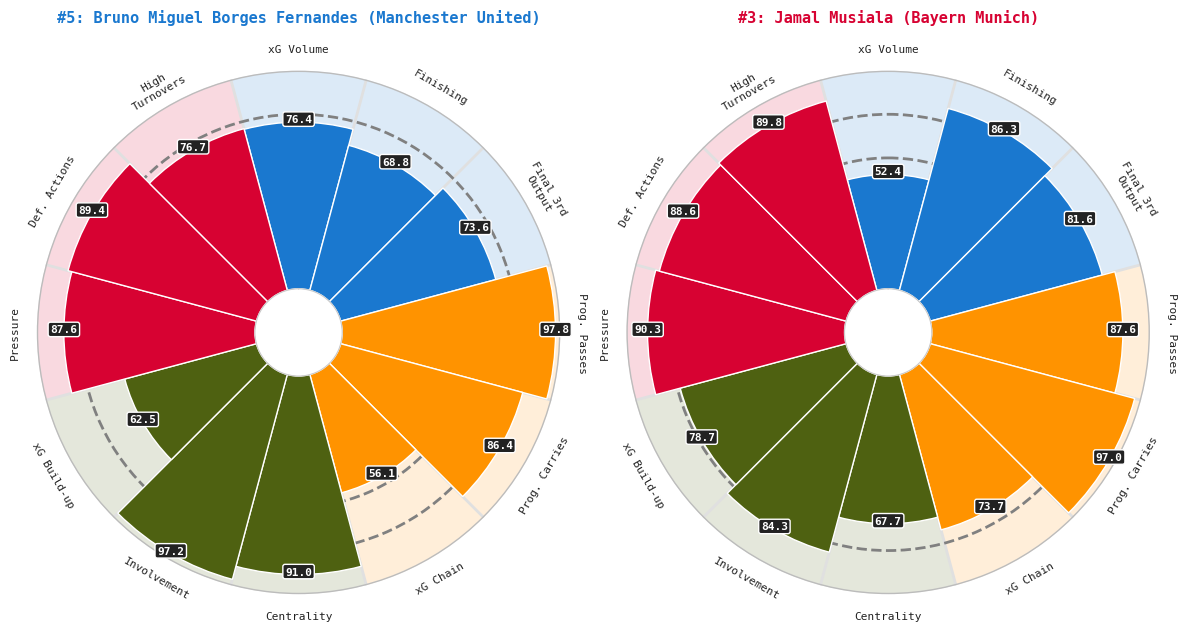

In [ ]:
# Compare two top players
fig = visualization.plot_comparison_pizzas(
    player_scores_final, 
    p1_name=player_scores_final['player'][5], 
    p2_name=player_scores_final['player'][3],
    p1_rank=5, 
    p2_rank=3
)
save_figure(fig, 'player_comparison_pizzas.png')
plt.show()

2026 World Cup Readiness Model
What We Built
A data-driven scoring system that ranks national teams on their predicted readiness for the 2026 World Cup, combining player quality metrics, tactical context, and tournament-specific factors.
Player Quality (the foundation)
Each player in our database is scored on overall_quality — a composite metric built from position-adjusted performance data including progressive carries, xG chain involvement, network centrality, pressure success, and build-up contribution. Crucially, a defender's 80 and a forward's 80 mean the same thing — the score is already position-normalised, so we're comparing apples to apples across a full squad.
How Teams Are Scored
For each national team we match their declared roster against our player database and compute five components:
Squad Quality — the average overall_quality of matched players. Treated as an unbiased sample of the full squad's attacking and midfield strength.
Star Power — the average quality of the top 3 matched players, above a baseline threshold. This captures the ceiling of a team — the difference between a squad that can win on any given day versus one that's consistently good.
Manager Stability — a multiplier based on how long the current manager has been in charge. Longer tenure means more ingrained patterns, squad trust, and tactical cohesion. A manager appointed in 2020 scores higher than one appointed in 2025.
Club Cohesion — how many players at a national team share club teammates. Players who already play together daily require less time to build combinations and understanding at international level.
Recovery Edge — players based at North American clubs (MLS, Liga MX) have a travel and acclimatisation advantage as 2026 hosts. No long-haul flights, familiar stadiums, similar timezones.
Host nations (USA, Mexico, Canada) receive an additional bonus reflecting home crowd advantage and familiarity with venues.
Honest Limitations
Our player database of 272 players skews towards attackers and midfielders — this is inherent to xG-based data pipelines, which naturally capture offensive contribution better than defensive work. Defenders are underrepresented equally across all squads, so relative rankings remain valid, but the model is best interpreted as attacking and midfield readiness rather than complete squad quality.
Coverage varies by team — we typically match 4–8 players per squad, representing 20–45% of declared rosters. We surface this as Coverage_Pct in our output so readers can calibrate their confidence in each team's score accordingly.

In [ ]:
import wc2026_matchup
importlib.reload(wc2026_matchup)
from wc2026_matchup import *

final_rankings = run_system_fit_engine(
    player_scores_final,
    team_success,
    archetype_success,
    rosters_2026,
    CLUB_MAPPING_2026,
    MANAGER_TENURE,
)

display(final_rankings)

plot_power_rankings(final_rankings)

NameError: name 'MANAGER_TENURE' is not defined

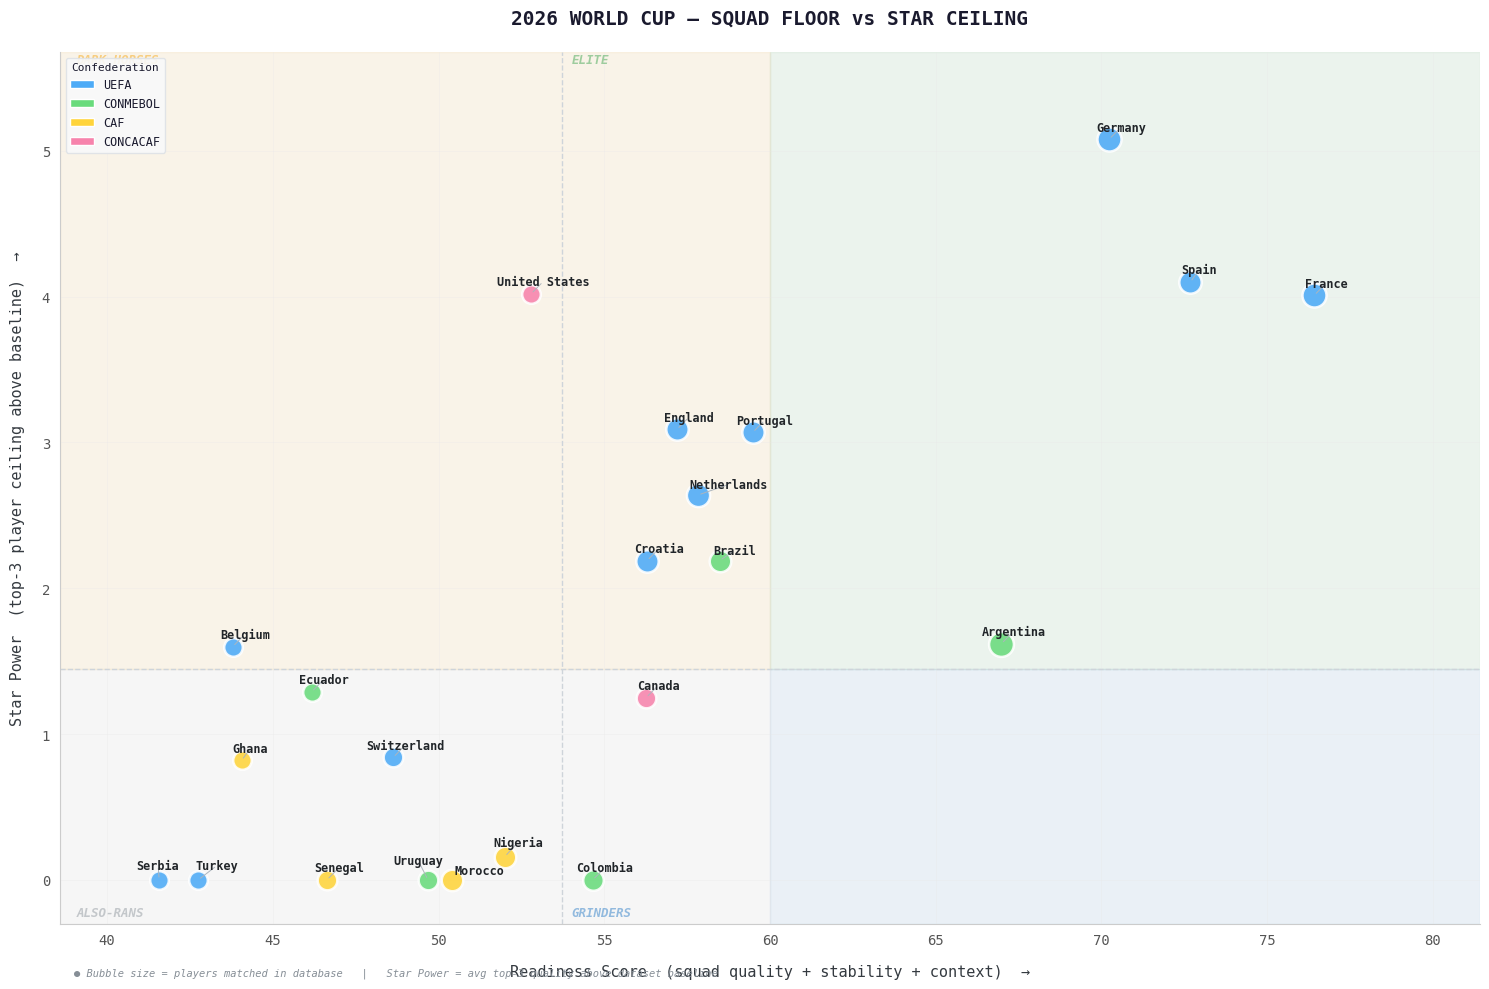

Saved: figures/wc2026_quadrant.png


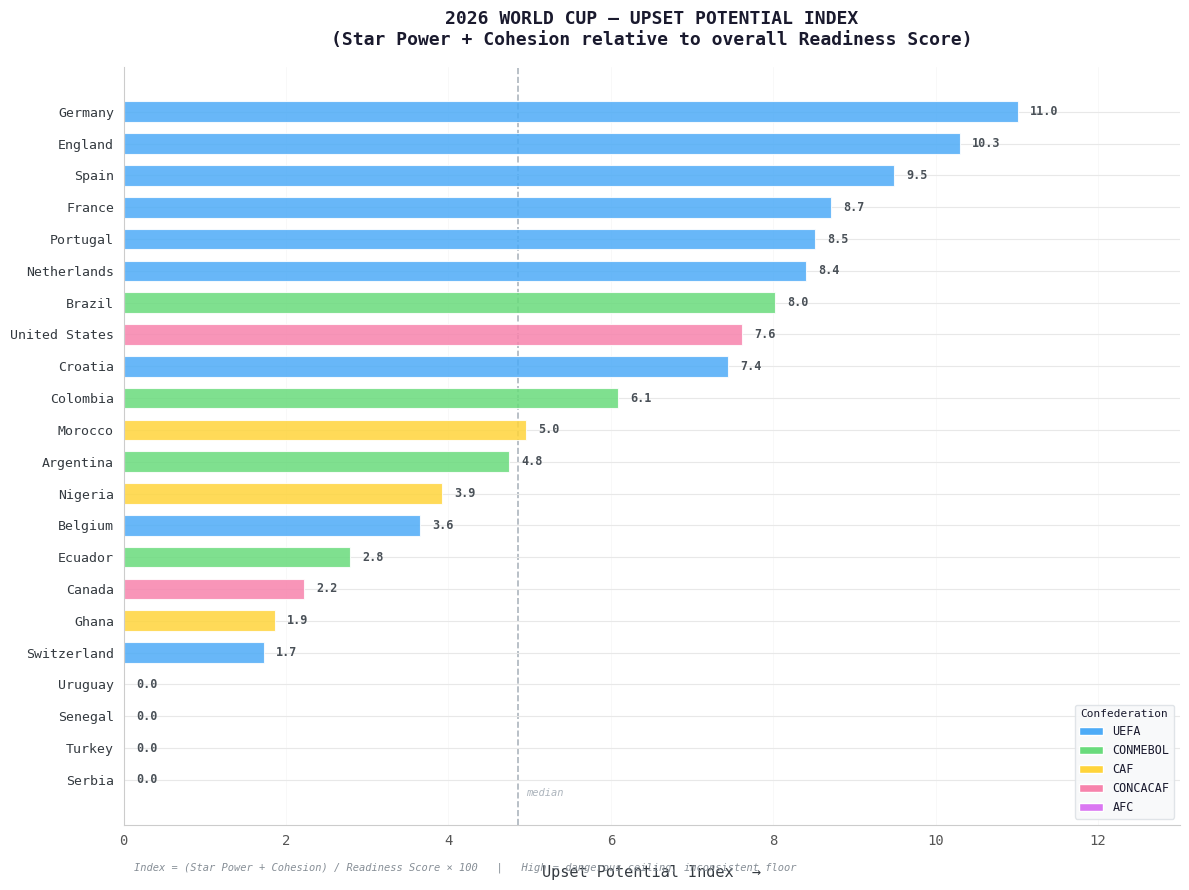

Saved: figures/wc2026_upset.png


,National_Team,Upset_Index,Star_Power,Cohesion,Readiness_Score
0,Germany,11.01,5.08,2.65,70.23
1,England,10.30,3.09,2.80,57.19
2,Spain,9.49,4.10,2.80,72.68
3,France,8.71,4.01,2.65,76.42
4,Portugal,8.52,3.07,2.00,59.48
5,Netherlands,8.40,2.64,2.22,57.83
6,Brazil,8.02,2.19,2.50,58.48
7,United States,7.62,4.02,0.00,52.79
8,Croatia,7.44,2.19,2.00,56.29
9,Colombia,6.09,0.00,3.33,54.65


In [ ]:

import visualization
importlib.reload(visualization)
from visualization import *

# Quadrant plot
plot_quadrant(final_rankings)
# Upset potential
plot_upset_index(final_rankings)
# See the index as a table too
compute_upset_index(final_rankings)[['National_Team', 'Upset_Index', 'Star_Power', 'Cohesion', 'Readiness_Score']]

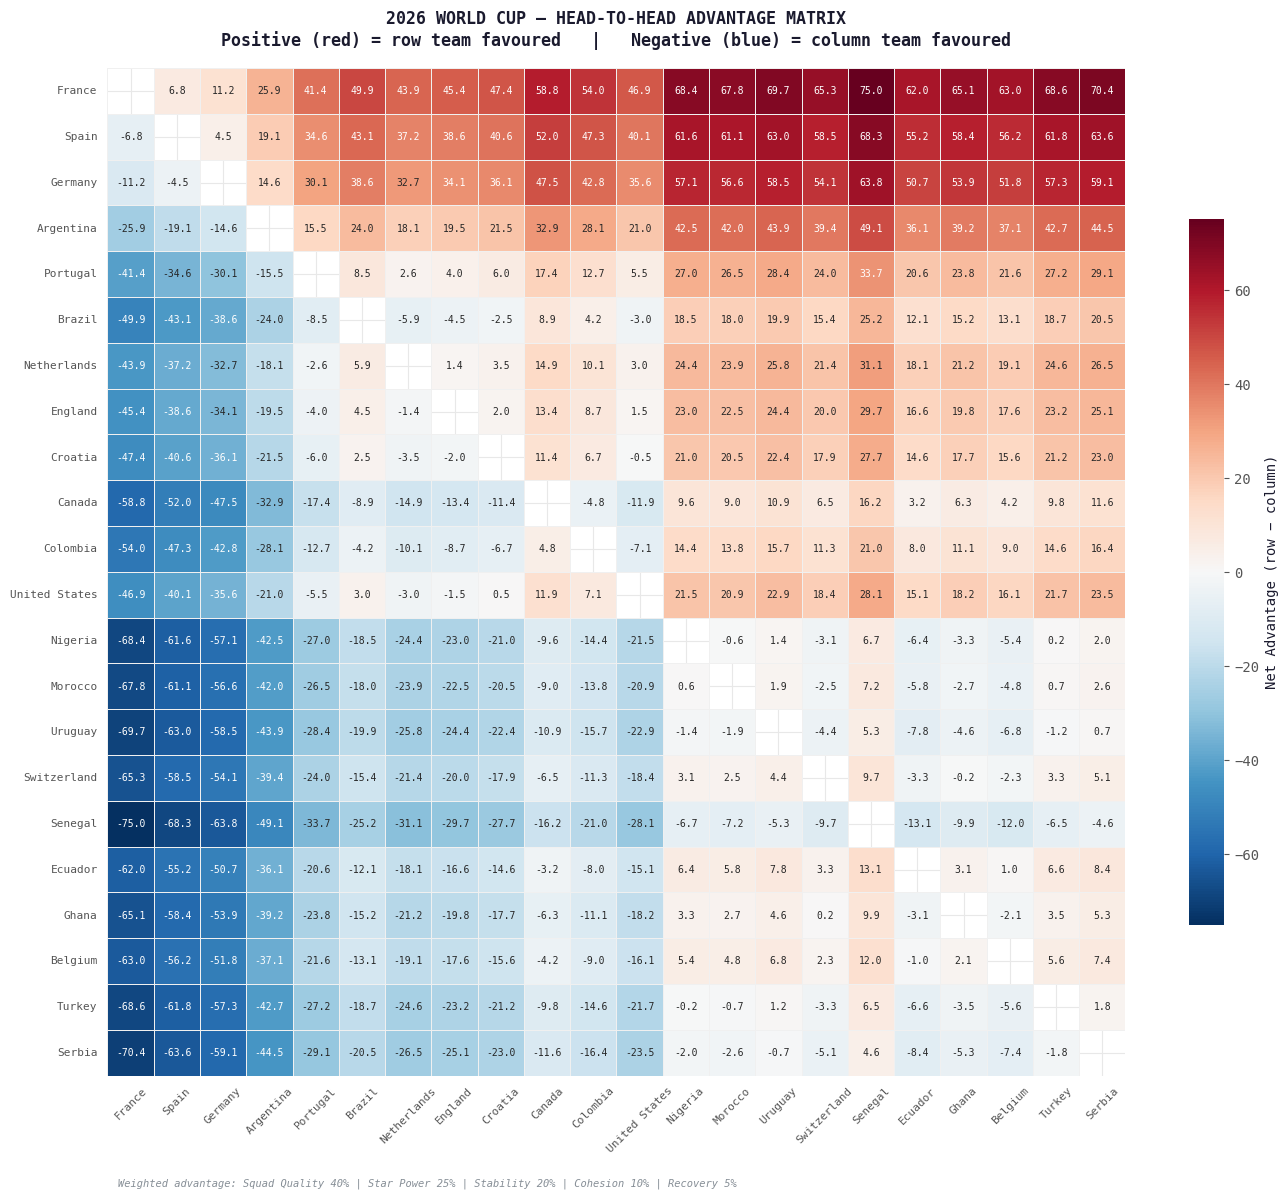

Saved: figures/wc2026_matchup_heatmap.png


In [ ]:
plot_matchup_heatmap(final_rankings)